In [94]:
import os, gc, sys, warnings
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_curve
from time import time
import datetime 
import pandas as pd
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.metrics import make_scorer
import matplotlib.pylab as plt



In [209]:
# load data
df_final= pd.read_pickle('complete.pkl')


In [210]:
df_final.describe(include = 'all')

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,5.905380e+05,590538.000000,5.905380e+05,590538.000000,590538,590538.000000,581605.0,588973.0,588961,586279.0,...,590526.0,589269.0,589269.0,589269.0,590526.000000,590526.000000,590526.000000,590526.000000,590526.000000,590526.000000
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,439668,NaN,NaN,NaN,384767,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.282270e+06,0.034990,7.372314e+06,NaN,NaN,9898.713741,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,109.764198,247.547089,162.097702,18.368195,42.069176,28.322451
std,1.704746e+05,0.183755,4.617231e+06,NaN,NaN,4901.165273,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,2269.589111,3979.604736,2792.652588,331.828278,473.211761,381.320618
min,2.987000e+06,0.000000,8.640000e+04,0.250977,NaN,1000.000000,100.0,100.0,NaN,100.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134634e+06,0.000000,3.027043e+06,43.312500,NaN,6019.000000,214.0,150.0,NaN,166.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306548e+06,68.750000,NaN,9678.000000,361.0,150.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.429905e+06,0.000000,1.124665e+07,125.000000,NaN,14182.750000,512.0,150.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [148]:
#Frequency encoder for high cardinality categorical features: replace the labels with the count 
def encode_FE(df,cols):
    for col in cols:
        vc = df[col].value_counts(dropna=True, normalize=True).to_dict()
        df[col] = df[col].map(vc)
        df[col] = df[col].astype('float32')
        


In [151]:
# Frequency Encode addr1, card1, card2, card3, card5, P_emaildomain
#cols = ['addr1','card1','card2','card3','card5','P_emaildomain']
#encode_FE(df_final,cols)

In [211]:
# Label Encoding for low cardinality features
def encode_lbl(df,cols):
    for col in cols:
        if df[col].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df[col].values) )
            df[col] = lbl.transform(list(df[col].values)) 


In [212]:
# Label encode card4, card6, ProductCD, M1-M9
cols= ['card4', 'card6', 'ProductCD','P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8','M9']
encode_lbl (df_final, cols)

In [213]:
# quick check for data
df_final.describe(include= 'all')

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,5.905380e+05,590538.000000,5.905380e+05,590538.000000,590538.000000,590538.000000,581605.0,588973.0,590538.000000,586279.0,...,590526.0,589269.0,589269.0,589269.0,590526.000000,590526.000000,590526.000000,590526.000000,590526.000000,590526.000000
mean,3.282270e+06,0.034990,7.372314e+06,NaN,3.220755,9898.713741,NaN,NaN,3.266310,NaN,...,NaN,NaN,NaN,NaN,109.764198,247.547089,162.097702,18.368195,42.069176,28.322451
std,1.704746e+05,0.183755,4.617231e+06,NaN,1.423928,4901.165273,NaN,0.0,1.035866,0.0,...,NaN,NaN,NaN,NaN,2269.589111,3979.604736,2792.652588,331.828278,473.211761,381.320618
min,2.987000e+06,0.000000,8.640000e+04,0.250977,0.000000,1000.000000,100.0,100.0,0.000000,100.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134634e+06,0.000000,3.027043e+06,43.312500,3.000000,6019.000000,214.0,150.0,2.000000,166.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306548e+06,68.750000,4.000000,9678.000000,361.0,150.0,4.000000,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.429905e+06,0.000000,1.124665e+07,125.000000,4.000000,14182.750000,512.0,150.0,4.000000,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,6452.000000,4.000000,18396.000000,600.0,231.0,4.000000,237.0,...,55136.0,4816.0,7520.0,4816.0,93736.000000,134021.000000,98476.000000,104060.000000,104060.000000,104060.000000


In [214]:
# split data into X and y
# TransactionID and TransactionDT were dropped because they are basically ids
X = df_final.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis =1 )
y = df_final['isFraud']

In [215]:
# split data into stratified train and test sets(80% train and 20% test)
seed= 42
x_train, x_test, y_train, y_test = train_test_split ( X,y, test_size = 0.20, shuffle= True, stratify= y, random_state = seed)


In [216]:
# train_validation_test set shapes

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
gc.collect()

(472430, 223) (472430,)
(118108, 223) (118108,)


18658

## Model training 

 rows of train = 377944 rows of holdout = 94486
[0]	validation_0-auc:0.839533
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.866673
[2]	validation_0-auc:0.86852
[3]	validation_0-auc:0.871974
[4]	validation_0-auc:0.874957
[5]	validation_0-auc:0.876936
[6]	validation_0-auc:0.87808
[7]	validation_0-auc:0.879092
[8]	validation_0-auc:0.878239
[9]	validation_0-auc:0.880639
[10]	validation_0-auc:0.881879
[11]	validation_0-auc:0.882094
[12]	validation_0-auc:0.882651
[13]	validation_0-auc:0.88454
[14]	validation_0-auc:0.885012
[15]	validation_0-auc:0.884954
[16]	validation_0-auc:0.885811
[17]	validation_0-auc:0.886052
[18]	validation_0-auc:0.886148
[19]	validation_0-auc:0.885872
[20]	validation_0-auc:0.885712
[21]	validation_0-auc:0.886312
[22]	validation_0-auc:0.886068
[23]	validation_0-auc:0.886259
[24]	validation_0-auc:0.886538
[25]	validation_0-auc:0.886793
[26]	validation_0-auc:0.887473
[27]	validation_0-auc:0.887557
[28]	validation_0-auc:0.887774
[

[257]	validation_0-auc:0.925507
[258]	validation_0-auc:0.925673
[259]	validation_0-auc:0.925701
[260]	validation_0-auc:0.925892
[261]	validation_0-auc:0.925992
[262]	validation_0-auc:0.92607
[263]	validation_0-auc:0.926219
[264]	validation_0-auc:0.926339
[265]	validation_0-auc:0.926581
[266]	validation_0-auc:0.92676
[267]	validation_0-auc:0.927009
[268]	validation_0-auc:0.927154
[269]	validation_0-auc:0.927278
[270]	validation_0-auc:0.927472
[271]	validation_0-auc:0.927554
[272]	validation_0-auc:0.927719
[273]	validation_0-auc:0.927879
[274]	validation_0-auc:0.928045
[275]	validation_0-auc:0.928306
[276]	validation_0-auc:0.928465
[277]	validation_0-auc:0.92862
[278]	validation_0-auc:0.928684
[279]	validation_0-auc:0.928819
[280]	validation_0-auc:0.928908
[281]	validation_0-auc:0.92905
[282]	validation_0-auc:0.929078
[283]	validation_0-auc:0.929264
[284]	validation_0-auc:0.92951
[285]	validation_0-auc:0.929619
[286]	validation_0-auc:0.929704
[287]	validation_0-auc:0.929813
[288]	validat

[514]	validation_0-auc:0.945655
[515]	validation_0-auc:0.945708
[516]	validation_0-auc:0.945751
[517]	validation_0-auc:0.945773
[518]	validation_0-auc:0.945846
[519]	validation_0-auc:0.945911
[520]	validation_0-auc:0.945916
[521]	validation_0-auc:0.945964
[522]	validation_0-auc:0.946008
[523]	validation_0-auc:0.946029
[524]	validation_0-auc:0.946031
[525]	validation_0-auc:0.94606
[526]	validation_0-auc:0.946091
[527]	validation_0-auc:0.946137
[528]	validation_0-auc:0.946182
[529]	validation_0-auc:0.946218
[530]	validation_0-auc:0.946297
[531]	validation_0-auc:0.946389
[532]	validation_0-auc:0.946447
[533]	validation_0-auc:0.946481
[534]	validation_0-auc:0.946462
[535]	validation_0-auc:0.94644
[536]	validation_0-auc:0.94646
[537]	validation_0-auc:0.946488
[538]	validation_0-auc:0.946509
[539]	validation_0-auc:0.946591
[540]	validation_0-auc:0.946652
[541]	validation_0-auc:0.946667
[542]	validation_0-auc:0.946737
[543]	validation_0-auc:0.946767
[544]	validation_0-auc:0.946776
[545]	valid

[772]	validation_0-auc:0.952358
[773]	validation_0-auc:0.952371
[774]	validation_0-auc:0.952379
[775]	validation_0-auc:0.952417
[776]	validation_0-auc:0.952438
[777]	validation_0-auc:0.952455
[778]	validation_0-auc:0.95247
[779]	validation_0-auc:0.952489
[780]	validation_0-auc:0.95249
[781]	validation_0-auc:0.952502
[782]	validation_0-auc:0.952537
[783]	validation_0-auc:0.95255
[784]	validation_0-auc:0.952582
[785]	validation_0-auc:0.952616
[786]	validation_0-auc:0.952627
[787]	validation_0-auc:0.952618
[788]	validation_0-auc:0.952628
[789]	validation_0-auc:0.952658
[790]	validation_0-auc:0.952672
[791]	validation_0-auc:0.952685
[792]	validation_0-auc:0.952711
[793]	validation_0-auc:0.952715
[794]	validation_0-auc:0.952723
[795]	validation_0-auc:0.95275
[796]	validation_0-auc:0.952781
[797]	validation_0-auc:0.952787
[798]	validation_0-auc:0.952811
[799]	validation_0-auc:0.952817
[800]	validation_0-auc:0.952867
[801]	validation_0-auc:0.952882
[802]	validation_0-auc:0.952908
[803]	valida

[1029]	validation_0-auc:0.955706
[1030]	validation_0-auc:0.955688
[1031]	validation_0-auc:0.955686
[1032]	validation_0-auc:0.955702
[1033]	validation_0-auc:0.955722
[1034]	validation_0-auc:0.95573
[1035]	validation_0-auc:0.955727
[1036]	validation_0-auc:0.955728
[1037]	validation_0-auc:0.955732
[1038]	validation_0-auc:0.955749
[1039]	validation_0-auc:0.955773
[1040]	validation_0-auc:0.955772
[1041]	validation_0-auc:0.955774
[1042]	validation_0-auc:0.955783
[1043]	validation_0-auc:0.955798
[1044]	validation_0-auc:0.955796
[1045]	validation_0-auc:0.9558
[1046]	validation_0-auc:0.955796
[1047]	validation_0-auc:0.955802
[1048]	validation_0-auc:0.9558
[1049]	validation_0-auc:0.955816
[1050]	validation_0-auc:0.955825
[1051]	validation_0-auc:0.955836
[1052]	validation_0-auc:0.955834
[1053]	validation_0-auc:0.955841
[1054]	validation_0-auc:0.955848
[1055]	validation_0-auc:0.955855
[1056]	validation_0-auc:0.955868
[1057]	validation_0-auc:0.955894
[1058]	validation_0-auc:0.955903
[1059]	validati

[1279]	validation_0-auc:0.957649
[1280]	validation_0-auc:0.957656
[1281]	validation_0-auc:0.957645
[1282]	validation_0-auc:0.95766
[1283]	validation_0-auc:0.957671
[1284]	validation_0-auc:0.957696
[1285]	validation_0-auc:0.957705
[1286]	validation_0-auc:0.957723
[1287]	validation_0-auc:0.957727
[1288]	validation_0-auc:0.957748
[1289]	validation_0-auc:0.957758
[1290]	validation_0-auc:0.95776
[1291]	validation_0-auc:0.957772
[1292]	validation_0-auc:0.957798
[1293]	validation_0-auc:0.957792
[1294]	validation_0-auc:0.957809
[1295]	validation_0-auc:0.9578
[1296]	validation_0-auc:0.957797
[1297]	validation_0-auc:0.957804
[1298]	validation_0-auc:0.957814
[1299]	validation_0-auc:0.957819
[1300]	validation_0-auc:0.95784
[1301]	validation_0-auc:0.957831
[1302]	validation_0-auc:0.957854
[1303]	validation_0-auc:0.957868
[1304]	validation_0-auc:0.957858
[1305]	validation_0-auc:0.957862
[1306]	validation_0-auc:0.957865
[1307]	validation_0-auc:0.957864
[1308]	validation_0-auc:0.957875
[1309]	validati

[1529]	validation_0-auc:0.958944
[1530]	validation_0-auc:0.958941
[1531]	validation_0-auc:0.958937
[1532]	validation_0-auc:0.958953
[1533]	validation_0-auc:0.958956
[1534]	validation_0-auc:0.958947
[1535]	validation_0-auc:0.958954
[1536]	validation_0-auc:0.95896
[1537]	validation_0-auc:0.958969
[1538]	validation_0-auc:0.958962
[1539]	validation_0-auc:0.958969
[1540]	validation_0-auc:0.958973
[1541]	validation_0-auc:0.95897
[1542]	validation_0-auc:0.958961
[1543]	validation_0-auc:0.958973
[1544]	validation_0-auc:0.958982
[1545]	validation_0-auc:0.958984
[1546]	validation_0-auc:0.958993
[1547]	validation_0-auc:0.958991
[1548]	validation_0-auc:0.95899
[1549]	validation_0-auc:0.958998
[1550]	validation_0-auc:0.959004
[1551]	validation_0-auc:0.959018
[1552]	validation_0-auc:0.959024
[1553]	validation_0-auc:0.959033
[1554]	validation_0-auc:0.959032
[1555]	validation_0-auc:0.959033
[1556]	validation_0-auc:0.959035
[1557]	validation_0-auc:0.95905
[1558]	validation_0-auc:0.95905
[1559]	validati

[1779]	validation_0-auc:0.959801
[1780]	validation_0-auc:0.959811
[1781]	validation_0-auc:0.959823
[1782]	validation_0-auc:0.959827
[1783]	validation_0-auc:0.95983
[1784]	validation_0-auc:0.959834
[1785]	validation_0-auc:0.959828
[1786]	validation_0-auc:0.95983
[1787]	validation_0-auc:0.959827
[1788]	validation_0-auc:0.959831
[1789]	validation_0-auc:0.959831
[1790]	validation_0-auc:0.959838
[1791]	validation_0-auc:0.959839
[1792]	validation_0-auc:0.959837
[1793]	validation_0-auc:0.959833
[1794]	validation_0-auc:0.959822
[1795]	validation_0-auc:0.959824
[1796]	validation_0-auc:0.959812
[1797]	validation_0-auc:0.959817
[1798]	validation_0-auc:0.959838
[1799]	validation_0-auc:0.959854
[1800]	validation_0-auc:0.959858
[1801]	validation_0-auc:0.959867
[1802]	validation_0-auc:0.959865
[1803]	validation_0-auc:0.959878
[1804]	validation_0-auc:0.959885
[1805]	validation_0-auc:0.959889
[1806]	validation_0-auc:0.959903
[1807]	validation_0-auc:0.959908
[1808]	validation_0-auc:0.959899
[1809]	valid

[27]	validation_0-auc:0.885234
[28]	validation_0-auc:0.885436
[29]	validation_0-auc:0.885453
[30]	validation_0-auc:0.885342
[31]	validation_0-auc:0.885665
[32]	validation_0-auc:0.885817
[33]	validation_0-auc:0.886177
[34]	validation_0-auc:0.886169
[35]	validation_0-auc:0.886549
[36]	validation_0-auc:0.887096
[37]	validation_0-auc:0.887482
[38]	validation_0-auc:0.887631
[39]	validation_0-auc:0.887631
[40]	validation_0-auc:0.887767
[41]	validation_0-auc:0.887991
[42]	validation_0-auc:0.888292
[43]	validation_0-auc:0.888313
[44]	validation_0-auc:0.888328
[45]	validation_0-auc:0.888581
[46]	validation_0-auc:0.888656
[47]	validation_0-auc:0.888575
[48]	validation_0-auc:0.888847
[49]	validation_0-auc:0.888949
[50]	validation_0-auc:0.889033
[51]	validation_0-auc:0.889227
[52]	validation_0-auc:0.889618
[53]	validation_0-auc:0.88978
[54]	validation_0-auc:0.889888
[55]	validation_0-auc:0.88997
[56]	validation_0-auc:0.890051
[57]	validation_0-auc:0.890501
[58]	validation_0-auc:0.890719
[59]	valid

[287]	validation_0-auc:0.926661
[288]	validation_0-auc:0.926723
[289]	validation_0-auc:0.926903
[290]	validation_0-auc:0.926994
[291]	validation_0-auc:0.927165
[292]	validation_0-auc:0.927248
[293]	validation_0-auc:0.927399
[294]	validation_0-auc:0.927522
[295]	validation_0-auc:0.927634
[296]	validation_0-auc:0.927777
[297]	validation_0-auc:0.927864
[298]	validation_0-auc:0.928007
[299]	validation_0-auc:0.928061
[300]	validation_0-auc:0.928255
[301]	validation_0-auc:0.928379
[302]	validation_0-auc:0.928575
[303]	validation_0-auc:0.928654
[304]	validation_0-auc:0.928766
[305]	validation_0-auc:0.928802
[306]	validation_0-auc:0.928918
[307]	validation_0-auc:0.929025
[308]	validation_0-auc:0.929071
[309]	validation_0-auc:0.92911
[310]	validation_0-auc:0.929354
[311]	validation_0-auc:0.929458
[312]	validation_0-auc:0.929534
[313]	validation_0-auc:0.929757
[314]	validation_0-auc:0.92978
[315]	validation_0-auc:0.929946
[316]	validation_0-auc:0.930076
[317]	validation_0-auc:0.930199
[318]	vali

[544]	validation_0-auc:0.94368
[545]	validation_0-auc:0.94372
[546]	validation_0-auc:0.943743
[547]	validation_0-auc:0.943771
[548]	validation_0-auc:0.943819
[549]	validation_0-auc:0.943811
[550]	validation_0-auc:0.943867
[551]	validation_0-auc:0.943914
[552]	validation_0-auc:0.943947
[553]	validation_0-auc:0.94397
[554]	validation_0-auc:0.944028
[555]	validation_0-auc:0.944081
[556]	validation_0-auc:0.944097
[557]	validation_0-auc:0.94412
[558]	validation_0-auc:0.944178
[559]	validation_0-auc:0.944209
[560]	validation_0-auc:0.94422
[561]	validation_0-auc:0.944282
[562]	validation_0-auc:0.944316
[563]	validation_0-auc:0.94433
[564]	validation_0-auc:0.944381
[565]	validation_0-auc:0.944401
[566]	validation_0-auc:0.944435
[567]	validation_0-auc:0.944456
[568]	validation_0-auc:0.94446
[569]	validation_0-auc:0.944493
[570]	validation_0-auc:0.944505
[571]	validation_0-auc:0.944521
[572]	validation_0-auc:0.944523
[573]	validation_0-auc:0.944555
[574]	validation_0-auc:0.944608
[575]	validatio

[801]	validation_0-auc:0.95023
[802]	validation_0-auc:0.950231
[803]	validation_0-auc:0.950248
[804]	validation_0-auc:0.950245
[805]	validation_0-auc:0.950253
[806]	validation_0-auc:0.950285
[807]	validation_0-auc:0.950298
[808]	validation_0-auc:0.950345
[809]	validation_0-auc:0.950365
[810]	validation_0-auc:0.950362
[811]	validation_0-auc:0.950342
[812]	validation_0-auc:0.950374
[813]	validation_0-auc:0.950379
[814]	validation_0-auc:0.950406
[815]	validation_0-auc:0.950416
[816]	validation_0-auc:0.950425
[817]	validation_0-auc:0.95045
[818]	validation_0-auc:0.950451
[819]	validation_0-auc:0.950463
[820]	validation_0-auc:0.950513
[821]	validation_0-auc:0.9505
[822]	validation_0-auc:0.950524
[823]	validation_0-auc:0.950562
[824]	validation_0-auc:0.950592
[825]	validation_0-auc:0.950586
[826]	validation_0-auc:0.95059
[827]	validation_0-auc:0.95061
[828]	validation_0-auc:0.950632
[829]	validation_0-auc:0.950654
[830]	validation_0-auc:0.950649
[831]	validation_0-auc:0.950655
[832]	validati

[1057]	validation_0-auc:0.953558
[1058]	validation_0-auc:0.95357
[1059]	validation_0-auc:0.953582
[1060]	validation_0-auc:0.953616
[1061]	validation_0-auc:0.953633
[1062]	validation_0-auc:0.953653
[1063]	validation_0-auc:0.953669
[1064]	validation_0-auc:0.95368
[1065]	validation_0-auc:0.95369
[1066]	validation_0-auc:0.953704
[1067]	validation_0-auc:0.953733
[1068]	validation_0-auc:0.953725
[1069]	validation_0-auc:0.953725
[1070]	validation_0-auc:0.95376
[1071]	validation_0-auc:0.95377
[1072]	validation_0-auc:0.953785
[1073]	validation_0-auc:0.953802
[1074]	validation_0-auc:0.953821
[1075]	validation_0-auc:0.953837
[1076]	validation_0-auc:0.953869
[1077]	validation_0-auc:0.953885
[1078]	validation_0-auc:0.953917
[1079]	validation_0-auc:0.953909
[1080]	validation_0-auc:0.953913
[1081]	validation_0-auc:0.953939
[1082]	validation_0-auc:0.953957
[1083]	validation_0-auc:0.953958
[1084]	validation_0-auc:0.953957
[1085]	validation_0-auc:0.954
[1086]	validation_0-auc:0.954013
[1087]	validation_

[1307]	validation_0-auc:0.956136
[1308]	validation_0-auc:0.956165
[1309]	validation_0-auc:0.95616
[1310]	validation_0-auc:0.95615
[1311]	validation_0-auc:0.95616
[1312]	validation_0-auc:0.956182
[1313]	validation_0-auc:0.956179
[1314]	validation_0-auc:0.956188
[1315]	validation_0-auc:0.956202
[1316]	validation_0-auc:0.956213
[1317]	validation_0-auc:0.956216
[1318]	validation_0-auc:0.95624
[1319]	validation_0-auc:0.956232
[1320]	validation_0-auc:0.956241
[1321]	validation_0-auc:0.956245
[1322]	validation_0-auc:0.956258
[1323]	validation_0-auc:0.956258
[1324]	validation_0-auc:0.956265
[1325]	validation_0-auc:0.956301
[1326]	validation_0-auc:0.956305
[1327]	validation_0-auc:0.95631
[1328]	validation_0-auc:0.956313
[1329]	validation_0-auc:0.956315
[1330]	validation_0-auc:0.956302
[1331]	validation_0-auc:0.956305
[1332]	validation_0-auc:0.956323
[1333]	validation_0-auc:0.956326
[1334]	validation_0-auc:0.956331
[1335]	validation_0-auc:0.956327
[1336]	validation_0-auc:0.956332
[1337]	validati

[1556]	validation_0-auc:0.957643
[1557]	validation_0-auc:0.957658
[1558]	validation_0-auc:0.957662
[1559]	validation_0-auc:0.957669
[1560]	validation_0-auc:0.95766
[1561]	validation_0-auc:0.957668
[1562]	validation_0-auc:0.957668
[1563]	validation_0-auc:0.957678
[1564]	validation_0-auc:0.957688
[1565]	validation_0-auc:0.957684
[1566]	validation_0-auc:0.957688
[1567]	validation_0-auc:0.957707
[1568]	validation_0-auc:0.957721
[1569]	validation_0-auc:0.957732
[1570]	validation_0-auc:0.95774
[1571]	validation_0-auc:0.957739
[1572]	validation_0-auc:0.957781
[1573]	validation_0-auc:0.957785
[1574]	validation_0-auc:0.957789
[1575]	validation_0-auc:0.957794
[1576]	validation_0-auc:0.957791
[1577]	validation_0-auc:0.957782
[1578]	validation_0-auc:0.957776
[1579]	validation_0-auc:0.957788
[1580]	validation_0-auc:0.957803
[1581]	validation_0-auc:0.957801
[1582]	validation_0-auc:0.957801
[1583]	validation_0-auc:0.957803
[1584]	validation_0-auc:0.957808
[1585]	validation_0-auc:0.957814
[1586]	valid

[1806]	validation_0-auc:0.958899
[1807]	validation_0-auc:0.958897
[1808]	validation_0-auc:0.958911
[1809]	validation_0-auc:0.95891
[1810]	validation_0-auc:0.958912
[1811]	validation_0-auc:0.958929
[1812]	validation_0-auc:0.958934
[1813]	validation_0-auc:0.958949
[1814]	validation_0-auc:0.958942
[1815]	validation_0-auc:0.958959
[1816]	validation_0-auc:0.958957
[1817]	validation_0-auc:0.958948
[1818]	validation_0-auc:0.958967
[1819]	validation_0-auc:0.958976
[1820]	validation_0-auc:0.958977
[1821]	validation_0-auc:0.958981
[1822]	validation_0-auc:0.958977
[1823]	validation_0-auc:0.958976
[1824]	validation_0-auc:0.958972
[1825]	validation_0-auc:0.958979
[1826]	validation_0-auc:0.958989
[1827]	validation_0-auc:0.959
[1828]	validation_0-auc:0.958994
[1829]	validation_0-auc:0.958993
[1830]	validation_0-auc:0.958995
[1831]	validation_0-auc:0.958992
[1832]	validation_0-auc:0.959
[1833]	validation_0-auc:0.959009
[1834]	validation_0-auc:0.959016
[1835]	validation_0-auc:0.959019
[1836]	validation

[56]	validation_0-auc:0.885954
[57]	validation_0-auc:0.886148
[58]	validation_0-auc:0.886429
[59]	validation_0-auc:0.886638
[60]	validation_0-auc:0.887013
[61]	validation_0-auc:0.887453
[62]	validation_0-auc:0.887413
[63]	validation_0-auc:0.88777
[64]	validation_0-auc:0.887905
[65]	validation_0-auc:0.888207
[66]	validation_0-auc:0.888325
[67]	validation_0-auc:0.888523
[68]	validation_0-auc:0.888707
[69]	validation_0-auc:0.888771
[70]	validation_0-auc:0.888929
[71]	validation_0-auc:0.889206
[72]	validation_0-auc:0.889429
[73]	validation_0-auc:0.889442
[74]	validation_0-auc:0.889492
[75]	validation_0-auc:0.889656
[76]	validation_0-auc:0.890044
[77]	validation_0-auc:0.890283
[78]	validation_0-auc:0.890466
[79]	validation_0-auc:0.890789
[80]	validation_0-auc:0.890959
[81]	validation_0-auc:0.891204
[82]	validation_0-auc:0.891357
[83]	validation_0-auc:0.891755
[84]	validation_0-auc:0.892064
[85]	validation_0-auc:0.892097
[86]	validation_0-auc:0.89226
[87]	validation_0-auc:0.892536
[88]	valid

[315]	validation_0-auc:0.926433
[316]	validation_0-auc:0.92655
[317]	validation_0-auc:0.92659
[318]	validation_0-auc:0.926646
[319]	validation_0-auc:0.926731
[320]	validation_0-auc:0.926756
[321]	validation_0-auc:0.926874
[322]	validation_0-auc:0.927034
[323]	validation_0-auc:0.927156
[324]	validation_0-auc:0.927241
[325]	validation_0-auc:0.927265
[326]	validation_0-auc:0.92742
[327]	validation_0-auc:0.927482
[328]	validation_0-auc:0.927693
[329]	validation_0-auc:0.927831
[330]	validation_0-auc:0.927884
[331]	validation_0-auc:0.927986
[332]	validation_0-auc:0.928082
[333]	validation_0-auc:0.92815
[334]	validation_0-auc:0.928306
[335]	validation_0-auc:0.928392
[336]	validation_0-auc:0.928468
[337]	validation_0-auc:0.928609
[338]	validation_0-auc:0.928682
[339]	validation_0-auc:0.928843
[340]	validation_0-auc:0.928869
[341]	validation_0-auc:0.928966
[342]	validation_0-auc:0.929023
[343]	validation_0-auc:0.929064
[344]	validation_0-auc:0.929226
[345]	validation_0-auc:0.929333
[346]	valida

[572]	validation_0-auc:0.942089
[573]	validation_0-auc:0.942112
[574]	validation_0-auc:0.942111
[575]	validation_0-auc:0.942183
[576]	validation_0-auc:0.942219
[577]	validation_0-auc:0.942241
[578]	validation_0-auc:0.942265
[579]	validation_0-auc:0.942311
[580]	validation_0-auc:0.942349
[581]	validation_0-auc:0.942393
[582]	validation_0-auc:0.942433
[583]	validation_0-auc:0.942447
[584]	validation_0-auc:0.942483
[585]	validation_0-auc:0.942506
[586]	validation_0-auc:0.942585
[587]	validation_0-auc:0.942621
[588]	validation_0-auc:0.942689
[589]	validation_0-auc:0.942747
[590]	validation_0-auc:0.942778
[591]	validation_0-auc:0.942877
[592]	validation_0-auc:0.942922
[593]	validation_0-auc:0.942942
[594]	validation_0-auc:0.943002
[595]	validation_0-auc:0.943035
[596]	validation_0-auc:0.943076
[597]	validation_0-auc:0.943111
[598]	validation_0-auc:0.943146
[599]	validation_0-auc:0.943167
[600]	validation_0-auc:0.943187
[601]	validation_0-auc:0.943213
[602]	validation_0-auc:0.943219
[603]	va

[829]	validation_0-auc:0.948685
[830]	validation_0-auc:0.948702
[831]	validation_0-auc:0.948722
[832]	validation_0-auc:0.948729
[833]	validation_0-auc:0.948744
[834]	validation_0-auc:0.94875
[835]	validation_0-auc:0.948755
[836]	validation_0-auc:0.948766
[837]	validation_0-auc:0.94875
[838]	validation_0-auc:0.948759
[839]	validation_0-auc:0.948787
[840]	validation_0-auc:0.948814
[841]	validation_0-auc:0.948829
[842]	validation_0-auc:0.948831
[843]	validation_0-auc:0.948878
[844]	validation_0-auc:0.948886
[845]	validation_0-auc:0.94889
[846]	validation_0-auc:0.948911
[847]	validation_0-auc:0.94893
[848]	validation_0-auc:0.948941
[849]	validation_0-auc:0.949004
[850]	validation_0-auc:0.949014
[851]	validation_0-auc:0.949062
[852]	validation_0-auc:0.949091
[853]	validation_0-auc:0.949146
[854]	validation_0-auc:0.949141
[855]	validation_0-auc:0.949146
[856]	validation_0-auc:0.949155
[857]	validation_0-auc:0.949181
[858]	validation_0-auc:0.949229
[859]	validation_0-auc:0.949257
[860]	valida

[1084]	validation_0-auc:0.952535
[1085]	validation_0-auc:0.952563
[1086]	validation_0-auc:0.952581
[1087]	validation_0-auc:0.9526
[1088]	validation_0-auc:0.952619
[1089]	validation_0-auc:0.952624
[1090]	validation_0-auc:0.952638
[1091]	validation_0-auc:0.952661
[1092]	validation_0-auc:0.952668
[1093]	validation_0-auc:0.952664
[1094]	validation_0-auc:0.952669
[1095]	validation_0-auc:0.952674
[1096]	validation_0-auc:0.952692
[1097]	validation_0-auc:0.952699
[1098]	validation_0-auc:0.952704
[1099]	validation_0-auc:0.952735
[1100]	validation_0-auc:0.952743
[1101]	validation_0-auc:0.952741
[1102]	validation_0-auc:0.952751
[1103]	validation_0-auc:0.952744
[1104]	validation_0-auc:0.952781
[1105]	validation_0-auc:0.952802
[1106]	validation_0-auc:0.952818
[1107]	validation_0-auc:0.952839
[1108]	validation_0-auc:0.952851
[1109]	validation_0-auc:0.952871
[1110]	validation_0-auc:0.952878
[1111]	validation_0-auc:0.95291
[1112]	validation_0-auc:0.95292
[1113]	validation_0-auc:0.952925
[1114]	validat

[1334]	validation_0-auc:0.954889
[1335]	validation_0-auc:0.954901
[1336]	validation_0-auc:0.954912
[1337]	validation_0-auc:0.954905
[1338]	validation_0-auc:0.95491
[1339]	validation_0-auc:0.954928
[1340]	validation_0-auc:0.954933
[1341]	validation_0-auc:0.954935
[1342]	validation_0-auc:0.954932
[1343]	validation_0-auc:0.954944
[1344]	validation_0-auc:0.954944
[1345]	validation_0-auc:0.954951
[1346]	validation_0-auc:0.954967
[1347]	validation_0-auc:0.95497
[1348]	validation_0-auc:0.954983
[1349]	validation_0-auc:0.954982
[1350]	validation_0-auc:0.954991
[1351]	validation_0-auc:0.955021
[1352]	validation_0-auc:0.955022
[1353]	validation_0-auc:0.955013
[1354]	validation_0-auc:0.955036
[1355]	validation_0-auc:0.955067
[1356]	validation_0-auc:0.955068
[1357]	validation_0-auc:0.95507
[1358]	validation_0-auc:0.955081
[1359]	validation_0-auc:0.955095
[1360]	validation_0-auc:0.95509
[1361]	validation_0-auc:0.955108
[1362]	validation_0-auc:0.955115
[1363]	validation_0-auc:0.955128
[1364]	validat

[1584]	validation_0-auc:0.956303
[1585]	validation_0-auc:0.956312
[1586]	validation_0-auc:0.956307
[1587]	validation_0-auc:0.956337
[1588]	validation_0-auc:0.956333
[1589]	validation_0-auc:0.956334
[1590]	validation_0-auc:0.956341
[1591]	validation_0-auc:0.956347
[1592]	validation_0-auc:0.95636
[1593]	validation_0-auc:0.95637
[1594]	validation_0-auc:0.956373
[1595]	validation_0-auc:0.956389
[1596]	validation_0-auc:0.956388
[1597]	validation_0-auc:0.956386
[1598]	validation_0-auc:0.956402
[1599]	validation_0-auc:0.956427
[1600]	validation_0-auc:0.956407
[1601]	validation_0-auc:0.956403
[1602]	validation_0-auc:0.95641
[1603]	validation_0-auc:0.9564
[1604]	validation_0-auc:0.956402
[1605]	validation_0-auc:0.956424
[1606]	validation_0-auc:0.956434
[1607]	validation_0-auc:0.956441
[1608]	validation_0-auc:0.956437
[1609]	validation_0-auc:0.956445
[1610]	validation_0-auc:0.956449
[1611]	validation_0-auc:0.956455
[1612]	validation_0-auc:0.956458
[1613]	validation_0-auc:0.956461
[1614]	validati

[1833]	validation_0-auc:0.957325
[1834]	validation_0-auc:0.957333
[1835]	validation_0-auc:0.957353
[1836]	validation_0-auc:0.957354
[1837]	validation_0-auc:0.957362
[1838]	validation_0-auc:0.957361
[1839]	validation_0-auc:0.957371
[1840]	validation_0-auc:0.957364
[1841]	validation_0-auc:0.957362
[1842]	validation_0-auc:0.957366
[1843]	validation_0-auc:0.957375
[1844]	validation_0-auc:0.957357
[1845]	validation_0-auc:0.95737
[1846]	validation_0-auc:0.957369
[1847]	validation_0-auc:0.957375
[1848]	validation_0-auc:0.957372
[1849]	validation_0-auc:0.957379
[1850]	validation_0-auc:0.957385
[1851]	validation_0-auc:0.957382
[1852]	validation_0-auc:0.957387
[1853]	validation_0-auc:0.957398
[1854]	validation_0-auc:0.957391
[1855]	validation_0-auc:0.957393
[1856]	validation_0-auc:0.957378
[1857]	validation_0-auc:0.95738
[1858]	validation_0-auc:0.957364
[1859]	validation_0-auc:0.957366
[1860]	validation_0-auc:0.957369
[1861]	validation_0-auc:0.957368
[1862]	validation_0-auc:0.957363
[1863]	valid

[85]	validation_0-auc:0.890051
[86]	validation_0-auc:0.890296
[87]	validation_0-auc:0.890519
[88]	validation_0-auc:0.890662
[89]	validation_0-auc:0.891104
[90]	validation_0-auc:0.891258
[91]	validation_0-auc:0.891313
[92]	validation_0-auc:0.891524
[93]	validation_0-auc:0.891637
[94]	validation_0-auc:0.891888
[95]	validation_0-auc:0.892202
[96]	validation_0-auc:0.892309
[97]	validation_0-auc:0.892516
[98]	validation_0-auc:0.892606
[99]	validation_0-auc:0.892785
[100]	validation_0-auc:0.893079
[101]	validation_0-auc:0.893292
[102]	validation_0-auc:0.893355
[103]	validation_0-auc:0.893735
[104]	validation_0-auc:0.89377
[105]	validation_0-auc:0.894113
[106]	validation_0-auc:0.894302
[107]	validation_0-auc:0.894384
[108]	validation_0-auc:0.894729
[109]	validation_0-auc:0.894888
[110]	validation_0-auc:0.894992
[111]	validation_0-auc:0.895139
[112]	validation_0-auc:0.895267
[113]	validation_0-auc:0.895376
[114]	validation_0-auc:0.89567
[115]	validation_0-auc:0.895877
[116]	validation_0-auc:0.

[343]	validation_0-auc:0.931546
[344]	validation_0-auc:0.931657
[345]	validation_0-auc:0.931768
[346]	validation_0-auc:0.931843
[347]	validation_0-auc:0.931901
[348]	validation_0-auc:0.932084
[349]	validation_0-auc:0.932177
[350]	validation_0-auc:0.932245
[351]	validation_0-auc:0.932388
[352]	validation_0-auc:0.932501
[353]	validation_0-auc:0.932658
[354]	validation_0-auc:0.932769
[355]	validation_0-auc:0.932829
[356]	validation_0-auc:0.93292
[357]	validation_0-auc:0.93305
[358]	validation_0-auc:0.933131
[359]	validation_0-auc:0.933277
[360]	validation_0-auc:0.933352
[361]	validation_0-auc:0.93337
[362]	validation_0-auc:0.93348
[363]	validation_0-auc:0.933554
[364]	validation_0-auc:0.933634
[365]	validation_0-auc:0.933674
[366]	validation_0-auc:0.93376
[367]	validation_0-auc:0.933858
[368]	validation_0-auc:0.934037
[369]	validation_0-auc:0.93413
[370]	validation_0-auc:0.934202
[371]	validation_0-auc:0.934326
[372]	validation_0-auc:0.934376
[373]	validation_0-auc:0.934448
[374]	validati

[600]	validation_0-auc:0.944969
[601]	validation_0-auc:0.94503
[602]	validation_0-auc:0.94506
[603]	validation_0-auc:0.945109
[604]	validation_0-auc:0.945129
[605]	validation_0-auc:0.945175
[606]	validation_0-auc:0.945205
[607]	validation_0-auc:0.945213
[608]	validation_0-auc:0.945256
[609]	validation_0-auc:0.945276
[610]	validation_0-auc:0.94536
[611]	validation_0-auc:0.945411
[612]	validation_0-auc:0.945426
[613]	validation_0-auc:0.945426
[614]	validation_0-auc:0.945472
[615]	validation_0-auc:0.945497
[616]	validation_0-auc:0.945518
[617]	validation_0-auc:0.945549
[618]	validation_0-auc:0.945584
[619]	validation_0-auc:0.945612
[620]	validation_0-auc:0.945669
[621]	validation_0-auc:0.945734
[622]	validation_0-auc:0.945765
[623]	validation_0-auc:0.9458
[624]	validation_0-auc:0.945847
[625]	validation_0-auc:0.945864
[626]	validation_0-auc:0.945879
[627]	validation_0-auc:0.945894
[628]	validation_0-auc:0.945916
[629]	validation_0-auc:0.945962
[630]	validation_0-auc:0.945986
[631]	validat

[858]	validation_0-auc:0.950643
[859]	validation_0-auc:0.950651
[860]	validation_0-auc:0.95065
[861]	validation_0-auc:0.950663
[862]	validation_0-auc:0.950667
[863]	validation_0-auc:0.950687
[864]	validation_0-auc:0.950689
[865]	validation_0-auc:0.950728
[866]	validation_0-auc:0.950751
[867]	validation_0-auc:0.950787
[868]	validation_0-auc:0.950817
[869]	validation_0-auc:0.950827
[870]	validation_0-auc:0.950849
[871]	validation_0-auc:0.950858
[872]	validation_0-auc:0.950873
[873]	validation_0-auc:0.950871
[874]	validation_0-auc:0.950898
[875]	validation_0-auc:0.950912
[876]	validation_0-auc:0.950925
[877]	validation_0-auc:0.950965
[878]	validation_0-auc:0.950998
[879]	validation_0-auc:0.951024
[880]	validation_0-auc:0.951048
[881]	validation_0-auc:0.951078
[882]	validation_0-auc:0.951064
[883]	validation_0-auc:0.95109
[884]	validation_0-auc:0.951092
[885]	validation_0-auc:0.951098
[886]	validation_0-auc:0.951103
[887]	validation_0-auc:0.951137
[888]	validation_0-auc:0.951135
[889]	vali

[1112]	validation_0-auc:0.953688
[1113]	validation_0-auc:0.953698
[1114]	validation_0-auc:0.953696
[1115]	validation_0-auc:0.95371
[1116]	validation_0-auc:0.953722
[1117]	validation_0-auc:0.95374
[1118]	validation_0-auc:0.953746
[1119]	validation_0-auc:0.953765
[1120]	validation_0-auc:0.953784
[1121]	validation_0-auc:0.953799
[1122]	validation_0-auc:0.953809
[1123]	validation_0-auc:0.953812
[1124]	validation_0-auc:0.953823
[1125]	validation_0-auc:0.953824
[1126]	validation_0-auc:0.953838
[1127]	validation_0-auc:0.953833
[1128]	validation_0-auc:0.953841
[1129]	validation_0-auc:0.953838
[1130]	validation_0-auc:0.953851
[1131]	validation_0-auc:0.953843
[1132]	validation_0-auc:0.953856
[1133]	validation_0-auc:0.953871
[1134]	validation_0-auc:0.953882
[1135]	validation_0-auc:0.953868
[1136]	validation_0-auc:0.953868
[1137]	validation_0-auc:0.953865
[1138]	validation_0-auc:0.953887
[1139]	validation_0-auc:0.953887
[1140]	validation_0-auc:0.953904
[1141]	validation_0-auc:0.953911
[1142]	valid

[1361]	validation_0-auc:0.955653
[1362]	validation_0-auc:0.955658
[1363]	validation_0-auc:0.955666
[1364]	validation_0-auc:0.955673
[1365]	validation_0-auc:0.955684
[1366]	validation_0-auc:0.955685
[1367]	validation_0-auc:0.955682
[1368]	validation_0-auc:0.955684
[1369]	validation_0-auc:0.955683
[1370]	validation_0-auc:0.955685
[1371]	validation_0-auc:0.955712
[1372]	validation_0-auc:0.955721
[1373]	validation_0-auc:0.955727
[1374]	validation_0-auc:0.955733
[1375]	validation_0-auc:0.955741
[1376]	validation_0-auc:0.955759
[1377]	validation_0-auc:0.955759
[1378]	validation_0-auc:0.955737
[1379]	validation_0-auc:0.955745
[1380]	validation_0-auc:0.955754
[1381]	validation_0-auc:0.955775
[1382]	validation_0-auc:0.955786
[1383]	validation_0-auc:0.955789
[1384]	validation_0-auc:0.955788
[1385]	validation_0-auc:0.955786
[1386]	validation_0-auc:0.955775
[1387]	validation_0-auc:0.955781
[1388]	validation_0-auc:0.955764
[1389]	validation_0-auc:0.955761
[1390]	validation_0-auc:0.955746
[1391]	val

[1610]	validation_0-auc:0.95673
[1611]	validation_0-auc:0.956745
[1612]	validation_0-auc:0.956775
[1613]	validation_0-auc:0.95679
[1614]	validation_0-auc:0.956784
[1615]	validation_0-auc:0.956795
[1616]	validation_0-auc:0.956785
[1617]	validation_0-auc:0.956779
[1618]	validation_0-auc:0.956773
[1619]	validation_0-auc:0.956775
[1620]	validation_0-auc:0.956766
[1621]	validation_0-auc:0.956771
[1622]	validation_0-auc:0.956767
[1623]	validation_0-auc:0.956774
[1624]	validation_0-auc:0.956791
[1625]	validation_0-auc:0.956776
[1626]	validation_0-auc:0.956782
[1627]	validation_0-auc:0.956775
[1628]	validation_0-auc:0.95677
[1629]	validation_0-auc:0.956767
[1630]	validation_0-auc:0.956788
[1631]	validation_0-auc:0.95681
[1632]	validation_0-auc:0.956807
[1633]	validation_0-auc:0.95679
[1634]	validation_0-auc:0.956787
[1635]	validation_0-auc:0.956785
[1636]	validation_0-auc:0.956793
[1637]	validation_0-auc:0.9568
[1638]	validation_0-auc:0.956818
[1639]	validation_0-auc:0.956813
[1640]	validation

[1860]	validation_0-auc:0.957564
[1861]	validation_0-auc:0.95757
[1862]	validation_0-auc:0.957574
[1863]	validation_0-auc:0.957584
[1864]	validation_0-auc:0.957595
[1865]	validation_0-auc:0.9576
[1866]	validation_0-auc:0.957607
[1867]	validation_0-auc:0.957607
[1868]	validation_0-auc:0.957626
[1869]	validation_0-auc:0.957624
[1870]	validation_0-auc:0.957622
[1871]	validation_0-auc:0.957614
[1872]	validation_0-auc:0.957631
[1873]	validation_0-auc:0.957616
[1874]	validation_0-auc:0.957615
[1875]	validation_0-auc:0.957627
[1876]	validation_0-auc:0.957624
[1877]	validation_0-auc:0.957626
[1878]	validation_0-auc:0.957632
[1879]	validation_0-auc:0.957647
[1880]	validation_0-auc:0.957666
[1881]	validation_0-auc:0.957671
[1882]	validation_0-auc:0.957674
[1883]	validation_0-auc:0.95767
[1884]	validation_0-auc:0.957677
[1885]	validation_0-auc:0.957679
[1886]	validation_0-auc:0.957667
[1887]	validation_0-auc:0.957671
[1888]	validation_0-auc:0.957686
[1889]	validation_0-auc:0.957694
[1890]	validat

[113]	validation_0-auc:0.904993
[114]	validation_0-auc:0.905464
[115]	validation_0-auc:0.905791
[116]	validation_0-auc:0.905898
[117]	validation_0-auc:0.906036
[118]	validation_0-auc:0.906134
[119]	validation_0-auc:0.906373
[120]	validation_0-auc:0.906416
[121]	validation_0-auc:0.906661
[122]	validation_0-auc:0.906922
[123]	validation_0-auc:0.906936
[124]	validation_0-auc:0.907168
[125]	validation_0-auc:0.907317
[126]	validation_0-auc:0.907515
[127]	validation_0-auc:0.907497
[128]	validation_0-auc:0.907774
[129]	validation_0-auc:0.908049
[130]	validation_0-auc:0.908397
[131]	validation_0-auc:0.908816
[132]	validation_0-auc:0.909178
[133]	validation_0-auc:0.909183
[134]	validation_0-auc:0.909426
[135]	validation_0-auc:0.909482
[136]	validation_0-auc:0.909566
[137]	validation_0-auc:0.909756
[138]	validation_0-auc:0.909962
[139]	validation_0-auc:0.910285
[140]	validation_0-auc:0.910467
[141]	validation_0-auc:0.910682
[142]	validation_0-auc:0.910878
[143]	validation_0-auc:0.910976
[144]	va

[370]	validation_0-auc:0.940556
[371]	validation_0-auc:0.940578
[372]	validation_0-auc:0.940615
[373]	validation_0-auc:0.940664
[374]	validation_0-auc:0.940794
[375]	validation_0-auc:0.940823
[376]	validation_0-auc:0.940869
[377]	validation_0-auc:0.940985
[378]	validation_0-auc:0.941113
[379]	validation_0-auc:0.941148
[380]	validation_0-auc:0.941174
[381]	validation_0-auc:0.941224
[382]	validation_0-auc:0.941253
[383]	validation_0-auc:0.941323
[384]	validation_0-auc:0.941408
[385]	validation_0-auc:0.941477
[386]	validation_0-auc:0.941538
[387]	validation_0-auc:0.941601
[388]	validation_0-auc:0.941751
[389]	validation_0-auc:0.941828
[390]	validation_0-auc:0.941855
[391]	validation_0-auc:0.941916
[392]	validation_0-auc:0.941985
[393]	validation_0-auc:0.942084
[394]	validation_0-auc:0.942136
[395]	validation_0-auc:0.942175
[396]	validation_0-auc:0.94223
[397]	validation_0-auc:0.942255
[398]	validation_0-auc:0.942324
[399]	validation_0-auc:0.942402
[400]	validation_0-auc:0.942421
[401]	val

[627]	validation_0-auc:0.952514
[628]	validation_0-auc:0.952515
[629]	validation_0-auc:0.952542
[630]	validation_0-auc:0.952547
[631]	validation_0-auc:0.952595
[632]	validation_0-auc:0.952676
[633]	validation_0-auc:0.952693
[634]	validation_0-auc:0.952741
[635]	validation_0-auc:0.952754
[636]	validation_0-auc:0.95275
[637]	validation_0-auc:0.952758
[638]	validation_0-auc:0.952801
[639]	validation_0-auc:0.952815
[640]	validation_0-auc:0.952834
[641]	validation_0-auc:0.95286
[642]	validation_0-auc:0.952876
[643]	validation_0-auc:0.952892
[644]	validation_0-auc:0.952903
[645]	validation_0-auc:0.952925
[646]	validation_0-auc:0.952926
[647]	validation_0-auc:0.952948
[648]	validation_0-auc:0.952966
[649]	validation_0-auc:0.953009
[650]	validation_0-auc:0.95309
[651]	validation_0-auc:0.953152
[652]	validation_0-auc:0.953178
[653]	validation_0-auc:0.953183
[654]	validation_0-auc:0.953211
[655]	validation_0-auc:0.953216
[656]	validation_0-auc:0.953204
[657]	validation_0-auc:0.953251
[658]	valid

[884]	validation_0-auc:0.95711
[885]	validation_0-auc:0.957119
[886]	validation_0-auc:0.957136
[887]	validation_0-auc:0.95714
[888]	validation_0-auc:0.957146
[889]	validation_0-auc:0.957152
[890]	validation_0-auc:0.957153
[891]	validation_0-auc:0.957174
[892]	validation_0-auc:0.957192
[893]	validation_0-auc:0.957211
[894]	validation_0-auc:0.957215
[895]	validation_0-auc:0.957223
[896]	validation_0-auc:0.957237
[897]	validation_0-auc:0.957236
[898]	validation_0-auc:0.957244
[899]	validation_0-auc:0.957273
[900]	validation_0-auc:0.957288
[901]	validation_0-auc:0.957315
[902]	validation_0-auc:0.957337
[903]	validation_0-auc:0.957345
[904]	validation_0-auc:0.957363
[905]	validation_0-auc:0.957377
[906]	validation_0-auc:0.957368
[907]	validation_0-auc:0.957364
[908]	validation_0-auc:0.95737
[909]	validation_0-auc:0.957367
[910]	validation_0-auc:0.957384
[911]	validation_0-auc:0.957398
[912]	validation_0-auc:0.957399
[913]	validation_0-auc:0.957412
[914]	validation_0-auc:0.957433
[915]	valid

[1137]	validation_0-auc:0.95967
[1138]	validation_0-auc:0.959684
[1139]	validation_0-auc:0.959699
[1140]	validation_0-auc:0.959708
[1141]	validation_0-auc:0.959732
[1142]	validation_0-auc:0.959734
[1143]	validation_0-auc:0.959751
[1144]	validation_0-auc:0.959755
[1145]	validation_0-auc:0.959758
[1146]	validation_0-auc:0.95977
[1147]	validation_0-auc:0.959776
[1148]	validation_0-auc:0.959771
[1149]	validation_0-auc:0.959768
[1150]	validation_0-auc:0.959764
[1151]	validation_0-auc:0.959778
[1152]	validation_0-auc:0.959778
[1153]	validation_0-auc:0.959791
[1154]	validation_0-auc:0.959806
[1155]	validation_0-auc:0.959827
[1156]	validation_0-auc:0.959838
[1157]	validation_0-auc:0.959843
[1158]	validation_0-auc:0.95986
[1159]	validation_0-auc:0.959863
[1160]	validation_0-auc:0.959868
[1161]	validation_0-auc:0.959858
[1162]	validation_0-auc:0.959868
[1163]	validation_0-auc:0.959858
[1164]	validation_0-auc:0.959871
[1165]	validation_0-auc:0.959865
[1166]	validation_0-auc:0.959899
[1167]	valida

[1387]	validation_0-auc:0.961212
[1388]	validation_0-auc:0.96121
[1389]	validation_0-auc:0.961204
[1390]	validation_0-auc:0.961215
[1391]	validation_0-auc:0.961211
[1392]	validation_0-auc:0.961211
[1393]	validation_0-auc:0.961211
[1394]	validation_0-auc:0.961226
[1395]	validation_0-auc:0.961223
[1396]	validation_0-auc:0.961218
[1397]	validation_0-auc:0.961227
[1398]	validation_0-auc:0.961214
[1399]	validation_0-auc:0.961225
[1400]	validation_0-auc:0.961235
[1401]	validation_0-auc:0.96124
[1402]	validation_0-auc:0.961258
[1403]	validation_0-auc:0.961253
[1404]	validation_0-auc:0.961265
[1405]	validation_0-auc:0.961267
[1406]	validation_0-auc:0.961258
[1407]	validation_0-auc:0.961258
[1408]	validation_0-auc:0.96126
[1409]	validation_0-auc:0.961274
[1410]	validation_0-auc:0.961279
[1411]	validation_0-auc:0.961267
[1412]	validation_0-auc:0.961289
[1413]	validation_0-auc:0.961286
[1414]	validation_0-auc:0.961297
[1415]	validation_0-auc:0.961303
[1416]	validation_0-auc:0.961321
[1417]	valida

[1636]	validation_0-auc:0.962234
[1637]	validation_0-auc:0.962241
[1638]	validation_0-auc:0.962243
[1639]	validation_0-auc:0.962252
[1640]	validation_0-auc:0.962256
[1641]	validation_0-auc:0.962274
[1642]	validation_0-auc:0.962273
[1643]	validation_0-auc:0.962285
[1644]	validation_0-auc:0.962278
[1645]	validation_0-auc:0.962279
[1646]	validation_0-auc:0.962281
[1647]	validation_0-auc:0.962278
[1648]	validation_0-auc:0.962278
[1649]	validation_0-auc:0.962286
[1650]	validation_0-auc:0.96228
[1651]	validation_0-auc:0.962283
[1652]	validation_0-auc:0.962298
[1653]	validation_0-auc:0.962319
[1654]	validation_0-auc:0.962317
[1655]	validation_0-auc:0.962309
[1656]	validation_0-auc:0.962294
[1657]	validation_0-auc:0.962295
[1658]	validation_0-auc:0.962303
[1659]	validation_0-auc:0.962313
[1660]	validation_0-auc:0.962306
[1661]	validation_0-auc:0.962309
[1662]	validation_0-auc:0.962311
[1663]	validation_0-auc:0.962314
[1664]	validation_0-auc:0.962307
[1665]	validation_0-auc:0.962303
[1666]	vali

[1886]	validation_0-auc:0.962901
[1887]	validation_0-auc:0.962898
[1888]	validation_0-auc:0.962908
[1889]	validation_0-auc:0.96291
[1890]	validation_0-auc:0.962918
[1891]	validation_0-auc:0.962928
[1892]	validation_0-auc:0.962935
[1893]	validation_0-auc:0.962932
[1894]	validation_0-auc:0.962938
[1895]	validation_0-auc:0.962949
[1896]	validation_0-auc:0.962947
[1897]	validation_0-auc:0.962953
[1898]	validation_0-auc:0.962945
[1899]	validation_0-auc:0.962948
[1900]	validation_0-auc:0.962958
[1901]	validation_0-auc:0.962962
[1902]	validation_0-auc:0.962968
[1903]	validation_0-auc:0.962976
[1904]	validation_0-auc:0.962982
[1905]	validation_0-auc:0.962991
[1906]	validation_0-auc:0.962991
[1907]	validation_0-auc:0.962983
[1908]	validation_0-auc:0.962967
[1909]	validation_0-auc:0.962968
[1910]	validation_0-auc:0.962964
[1911]	validation_0-auc:0.962969
[1912]	validation_0-auc:0.962967
[1913]	validation_0-auc:0.962972
[1914]	validation_0-auc:0.962988
[1915]	validation_0-auc:0.962975
[1916]	vali

C:\Users\hawia\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\hawia\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\hawia\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


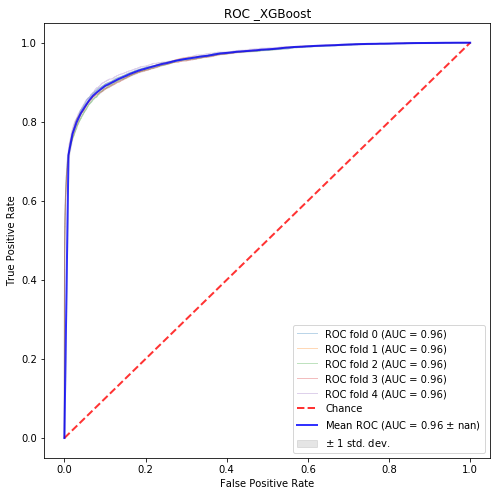

In [260]:
# Run classifier with cross-validation and plot ROC curves
import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve, auc


param1 = {'max_depth': 12,
          'learning_rate':0.02,          
          'min_child_weight': 5,
           'subsample': 0.5,
          'colsample_bytree': 0.4,
          'feature_fraction': 0.5,
          'max_delta_step': 3,
          'bagging_fraction':0.4,
          'tree_method': 'hist'
                                            }
#preds = np.zeros(len(x_test))
cv = StratifiedKFold(n_splits=5, random_state= 42, shuffle= True)
classifier = XGBClassifier(objective= 'binary:logistic',
                          n_estimators=2000, 
                            verbose = 100,
                            eval_metric='auc',
                              **param1,
                              random_state= 42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))


i = 0
for trn_idx, val_idx in cv.split(x_train, y_train):
    x_trn, x_val = x_train.iloc[trn_idx, :], x_train.iloc[val_idx, :]
    y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]
    print(' rows of train =',len(trn_idx),'rows of holdout =',len(val_idx))

    model= classifier.fit(x_trn, y_trn, eval_set=[(x_val, y_val)], early_stopping_rounds = 100)
    probas_ = model.predict_proba(x_val)
    # predict for test set
    #preds += model.predict_proba(x_test)[:,1]/cv.n_splits

    # Compute PR_ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_val, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i,roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr= np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC _XGBoost')
plt.legend(loc="lower right")
plt.show()

In [261]:
#Extracting the best iteration
best_iteration = model.get_booster ().best_ntree_limit
best_iteration


2000

## Prediction using parameters from best iteration

In [262]:
# prediction
preds = model.predict_proba(x_test, ntree_limit= best_iteration)[:, 1]

In [267]:
#Printing the classification report
from sklearn.metrics import classification_report, confusion_matrix
for i in range(0,len(y_test)):
    if preds[i]>=.5:       # setting threshold to .5
       preds[i]=1
    else:  
       preds[i]=0
print(confusion_matrix(y_test, preds))
print(classification_report (y_test, preds))
auc = roc_auc_score(y_test,preds)
print(f'ROC_AUC: {auc}')

[[113697    278]
 [  1668   2465]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.90      0.60      0.72      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.80      0.85    118108
weighted avg       0.98      0.98      0.98    118108

ROC_AUC: 0.7969899673326258


## Feature Importance

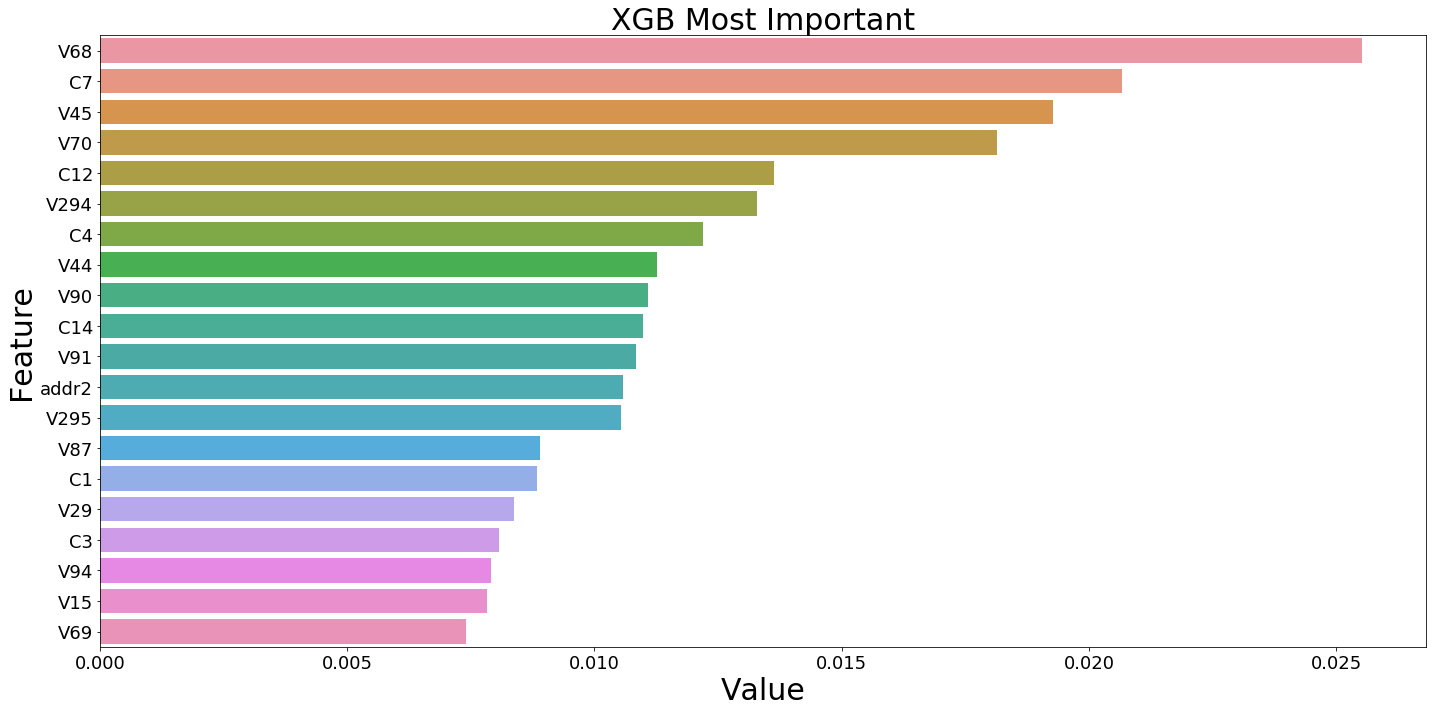

In [293]:
import seaborn as sns
cols = list( x_train.columns )
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
b= sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
b.set_xlabel("Value",fontsize=30)
b.set_ylabel("Feature",fontsize=30)
b.tick_params(labelsize=18)

plt.title('XGB Most Important', fontsize= 30)
plt.tight_layout()
plt.show()

Xgb: f1=0.717 PR_AUC=0.755


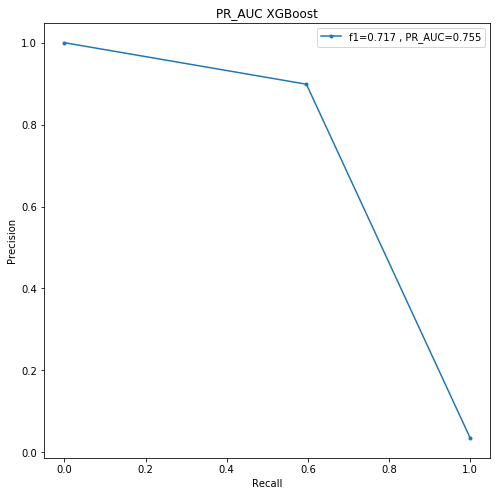

In [288]:
# calculate precision-recall curve
from sklearn.metrics import f1_score, auc

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, preds)
xgb_f1, xgb_PR_auc = f1_score(y_test, preds), auc(xgb_recall, xgb_precision)
print('Xgb: f1=%.3f PR_AUC=%.3f' % (xgb_f1, xgb_PR_auc))
plt.figure(figsize=(8, 8))
plt.plot(xgb_recall, xgb_precision, marker='.', label='f1=%.3f , PR_AUC=%.3f' % (xgb_f1, xgb_PR_auc))
# plot title
plt.title('PR_AUC XGBoost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()


0.7969899673326258


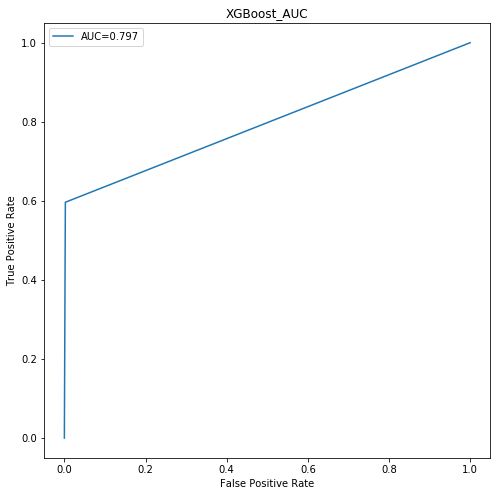

In [289]:
# calculate and print the roc curve
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, preds)
xgb_auc = auc(xgb_fpr, xgb_tpr)
print(xgb_auc)
plt.figure(figsize=(8,8))
plt.plot(xgb_fpr, xgb_tpr, label='AUC=%.3f' % ( xgb_auc))
plt.title('XGBoost_AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


## XGboost with balanced dataset with random undersampling

In [294]:
train= pd.concat([x_train, y_train], axis =1)
train.head(10)
train.isFraud.value_counts()

0    455900
1     16530
Name: isFraud, dtype: int64

In [295]:
# Class count
count_class_0, count_class_1 = train.isFraud.value_counts()

# Divide by class
df_class_0 = train[train['isFraud'] == 0]
df_class_1 = train[train['isFraud'] == 1]

Random under-sampling:
1    16530
0    16530
Name: isFraud, dtype: int64


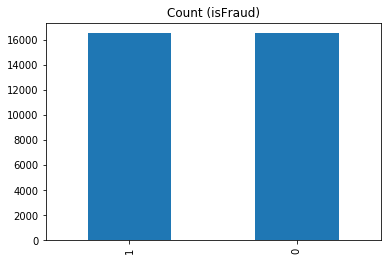

In [296]:
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under.isFraud.value_counts())

df_train_under.isFraud.value_counts().plot(kind='bar', title='Count (isFraud)');

In [297]:
df_train_under.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33060 entries, 679 to 443417
Columns: 224 entries, TransactionAmt to isFraud
dtypes: float16(191), float32(18), int16(1), int64(13), int8(1)
memory usage: 17.9 MB


In [308]:
# drop TransactionID since it is an index and doesn't add any value to the model

x_train_u = df_train_under.drop(['isFraud'], axis =1 )
y_train_u = df_train_under['isFraud']


## model training

 rows of train = 21158 rows of holdout = 5290
[0]	validation_0-auc:0.812148
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.823004
[2]	validation_0-auc:0.828649
[3]	validation_0-auc:0.83208
[4]	validation_0-auc:0.835505
[5]	validation_0-auc:0.836885
[6]	validation_0-auc:0.844766
[7]	validation_0-auc:0.845874
[8]	validation_0-auc:0.852976
[9]	validation_0-auc:0.856499
[10]	validation_0-auc:0.857931
[11]	validation_0-auc:0.859747
[12]	validation_0-auc:0.860791
[13]	validation_0-auc:0.861393
[14]	validation_0-auc:0.866624
[15]	validation_0-auc:0.867737
[16]	validation_0-auc:0.868572
[17]	validation_0-auc:0.869581
[18]	validation_0-auc:0.873104
[19]	validation_0-auc:0.874078
[20]	validation_0-auc:0.874837
[21]	validation_0-auc:0.875382
[22]	validation_0-auc:0.875627
[23]	validation_0-auc:0.875967
[24]	validation_0-auc:0.876033
[25]	validation_0-auc:0.876783
[26]	validation_0-auc:0.878453
[27]	validation_0-auc:0.879491
[28]	validation_0-auc:0.880064
[

[258]	validation_0-auc:0.924344
[259]	validation_0-auc:0.92437
[260]	validation_0-auc:0.924444
[261]	validation_0-auc:0.924554
[262]	validation_0-auc:0.924627
[263]	validation_0-auc:0.92468
[264]	validation_0-auc:0.924754
[265]	validation_0-auc:0.92481
[266]	validation_0-auc:0.924854
[267]	validation_0-auc:0.92493
[268]	validation_0-auc:0.925048
[269]	validation_0-auc:0.925137
[270]	validation_0-auc:0.925223
[271]	validation_0-auc:0.925286
[272]	validation_0-auc:0.925351
[273]	validation_0-auc:0.925401
[274]	validation_0-auc:0.925445
[275]	validation_0-auc:0.925515
[276]	validation_0-auc:0.925569
[277]	validation_0-auc:0.92563
[278]	validation_0-auc:0.925714
[279]	validation_0-auc:0.925762
[280]	validation_0-auc:0.925801
[281]	validation_0-auc:0.925839
[282]	validation_0-auc:0.925887
[283]	validation_0-auc:0.925958
[284]	validation_0-auc:0.925999
[285]	validation_0-auc:0.926018
[286]	validation_0-auc:0.926081
[287]	validation_0-auc:0.926122
[288]	validation_0-auc:0.926115
[289]	validat

[515]	validation_0-auc:0.934123
[516]	validation_0-auc:0.934134
[517]	validation_0-auc:0.934139
[518]	validation_0-auc:0.934153
[519]	validation_0-auc:0.934149
[520]	validation_0-auc:0.934164
[521]	validation_0-auc:0.934207
[522]	validation_0-auc:0.934233
[523]	validation_0-auc:0.934246
[524]	validation_0-auc:0.93424
[525]	validation_0-auc:0.934252
[526]	validation_0-auc:0.934252
[527]	validation_0-auc:0.934293
[528]	validation_0-auc:0.934311
[529]	validation_0-auc:0.934344
[530]	validation_0-auc:0.934341
[531]	validation_0-auc:0.934345
[532]	validation_0-auc:0.934338
[533]	validation_0-auc:0.934366
[534]	validation_0-auc:0.934403
[535]	validation_0-auc:0.934409
[536]	validation_0-auc:0.934407
[537]	validation_0-auc:0.934433
[538]	validation_0-auc:0.934461
[539]	validation_0-auc:0.934472
[540]	validation_0-auc:0.934486
[541]	validation_0-auc:0.934493
[542]	validation_0-auc:0.934528
[543]	validation_0-auc:0.934536
[544]	validation_0-auc:0.934557
[545]	validation_0-auc:0.934566
[546]	val

[772]	validation_0-auc:0.937564
[773]	validation_0-auc:0.937574
[774]	validation_0-auc:0.93757
[775]	validation_0-auc:0.937558
[776]	validation_0-auc:0.937568
[777]	validation_0-auc:0.937606
[778]	validation_0-auc:0.937616
[779]	validation_0-auc:0.937618
[780]	validation_0-auc:0.937657
[781]	validation_0-auc:0.937662
[782]	validation_0-auc:0.937674
[783]	validation_0-auc:0.937677
[784]	validation_0-auc:0.937683
[785]	validation_0-auc:0.937678
[786]	validation_0-auc:0.937681
[787]	validation_0-auc:0.937689
[788]	validation_0-auc:0.937711
[789]	validation_0-auc:0.937719
[790]	validation_0-auc:0.937728
[791]	validation_0-auc:0.937719
[792]	validation_0-auc:0.937725
[793]	validation_0-auc:0.937726
[794]	validation_0-auc:0.937716
[795]	validation_0-auc:0.937736
[796]	validation_0-auc:0.937766
[797]	validation_0-auc:0.937769
[798]	validation_0-auc:0.937774
[799]	validation_0-auc:0.937775
[800]	validation_0-auc:0.937776
[801]	validation_0-auc:0.937773
[802]	validation_0-auc:0.937818
[803]	val

[1029]	validation_0-auc:0.939544
[1030]	validation_0-auc:0.939545
[1031]	validation_0-auc:0.939548
[1032]	validation_0-auc:0.939549
[1033]	validation_0-auc:0.939541
[1034]	validation_0-auc:0.939549
[1035]	validation_0-auc:0.939561
[1036]	validation_0-auc:0.939569
[1037]	validation_0-auc:0.939575
[1038]	validation_0-auc:0.939589
[1039]	validation_0-auc:0.939594
[1040]	validation_0-auc:0.939604
[1041]	validation_0-auc:0.939602
[1042]	validation_0-auc:0.939608
[1043]	validation_0-auc:0.939592
[1044]	validation_0-auc:0.939608
[1045]	validation_0-auc:0.939614
[1046]	validation_0-auc:0.93962
[1047]	validation_0-auc:0.93962
[1048]	validation_0-auc:0.939622
[1049]	validation_0-auc:0.939628
[1050]	validation_0-auc:0.939633
[1051]	validation_0-auc:0.939636
[1052]	validation_0-auc:0.939625
[1053]	validation_0-auc:0.939636
[1054]	validation_0-auc:0.939639
[1055]	validation_0-auc:0.939644
[1056]	validation_0-auc:0.939633
[1057]	validation_0-auc:0.939652
[1058]	validation_0-auc:0.93965
[1059]	valida

[1278]	validation_0-auc:0.94017
[1279]	validation_0-auc:0.940168
[1280]	validation_0-auc:0.940161
[1281]	validation_0-auc:0.94016
[1282]	validation_0-auc:0.940162
[1283]	validation_0-auc:0.940155
[1284]	validation_0-auc:0.940154
[1285]	validation_0-auc:0.940154
[1286]	validation_0-auc:0.940155
[1287]	validation_0-auc:0.940168
[1288]	validation_0-auc:0.940164
[1289]	validation_0-auc:0.94015
[1290]	validation_0-auc:0.940167
[1291]	validation_0-auc:0.940161
[1292]	validation_0-auc:0.940158
[1293]	validation_0-auc:0.940156
[1294]	validation_0-auc:0.940154
[1295]	validation_0-auc:0.940157
[1296]	validation_0-auc:0.94016
[1297]	validation_0-auc:0.940163
[1298]	validation_0-auc:0.940159
[1299]	validation_0-auc:0.940157
[1300]	validation_0-auc:0.940157
[1301]	validation_0-auc:0.940165
[1302]	validation_0-auc:0.940176
[1303]	validation_0-auc:0.94017
[1304]	validation_0-auc:0.940172
[1305]	validation_0-auc:0.940166
[1306]	validation_0-auc:0.940183
[1307]	validation_0-auc:0.940181
[1308]	validati

[1527]	validation_0-auc:0.940571
[1528]	validation_0-auc:0.940571
[1529]	validation_0-auc:0.940566
[1530]	validation_0-auc:0.940568
[1531]	validation_0-auc:0.94058
[1532]	validation_0-auc:0.940567
[1533]	validation_0-auc:0.940572
[1534]	validation_0-auc:0.940589
[1535]	validation_0-auc:0.940591
[1536]	validation_0-auc:0.94059
[1537]	validation_0-auc:0.94059
[1538]	validation_0-auc:0.94058
[1539]	validation_0-auc:0.940586
[1540]	validation_0-auc:0.940585
[1541]	validation_0-auc:0.940591
[1542]	validation_0-auc:0.9406
[1543]	validation_0-auc:0.9406
[1544]	validation_0-auc:0.940604
[1545]	validation_0-auc:0.940606
[1546]	validation_0-auc:0.940612
[1547]	validation_0-auc:0.940619
[1548]	validation_0-auc:0.940614
[1549]	validation_0-auc:0.940613
[1550]	validation_0-auc:0.940616
[1551]	validation_0-auc:0.940613
[1552]	validation_0-auc:0.940612
[1553]	validation_0-auc:0.940608
[1554]	validation_0-auc:0.940605
[1555]	validation_0-auc:0.94061
[1556]	validation_0-auc:0.940617
[1557]	validation_0

[1777]	validation_0-auc:0.940948
[1778]	validation_0-auc:0.940952
[1779]	validation_0-auc:0.94096
[1780]	validation_0-auc:0.94097
[1781]	validation_0-auc:0.940965
[1782]	validation_0-auc:0.940965
[1783]	validation_0-auc:0.940979
[1784]	validation_0-auc:0.940978
[1785]	validation_0-auc:0.940971
[1786]	validation_0-auc:0.940971
[1787]	validation_0-auc:0.940979
[1788]	validation_0-auc:0.940959
[1789]	validation_0-auc:0.940952
[1790]	validation_0-auc:0.940955
[1791]	validation_0-auc:0.940949
[1792]	validation_0-auc:0.940943
[1793]	validation_0-auc:0.940948
[1794]	validation_0-auc:0.940958
[1795]	validation_0-auc:0.940961
[1796]	validation_0-auc:0.940959
[1797]	validation_0-auc:0.940964
[1798]	validation_0-auc:0.940973
[1799]	validation_0-auc:0.94097
[1800]	validation_0-auc:0.940976
[1801]	validation_0-auc:0.940983
[1802]	validation_0-auc:0.940984
[1803]	validation_0-auc:0.940973
[1804]	validation_0-auc:0.940983
[1805]	validation_0-auc:0.940983
[1806]	validation_0-auc:0.940986
[1807]	valida

[25]	validation_0-auc:0.889274
[26]	validation_0-auc:0.889684
[27]	validation_0-auc:0.890027
[28]	validation_0-auc:0.89264
[29]	validation_0-auc:0.892845
[30]	validation_0-auc:0.893454
[31]	validation_0-auc:0.894071
[32]	validation_0-auc:0.894425
[33]	validation_0-auc:0.89476
[34]	validation_0-auc:0.89504
[35]	validation_0-auc:0.895213
[36]	validation_0-auc:0.895627
[37]	validation_0-auc:0.896238
[38]	validation_0-auc:0.896712
[39]	validation_0-auc:0.897073
[40]	validation_0-auc:0.897243
[41]	validation_0-auc:0.898246
[42]	validation_0-auc:0.898575
[43]	validation_0-auc:0.898819
[44]	validation_0-auc:0.899173
[45]	validation_0-auc:0.89953
[46]	validation_0-auc:0.899952
[47]	validation_0-auc:0.90023
[48]	validation_0-auc:0.900857
[49]	validation_0-auc:0.901042
[50]	validation_0-auc:0.901488
[51]	validation_0-auc:0.901767
[52]	validation_0-auc:0.902085
[53]	validation_0-auc:0.902387
[54]	validation_0-auc:0.902589
[55]	validation_0-auc:0.902772
[56]	validation_0-auc:0.903159
[57]	validati

[285]	validation_0-auc:0.933009
[286]	validation_0-auc:0.93305
[287]	validation_0-auc:0.933089
[288]	validation_0-auc:0.933111
[289]	validation_0-auc:0.933142
[290]	validation_0-auc:0.933231
[291]	validation_0-auc:0.933222
[292]	validation_0-auc:0.933234
[293]	validation_0-auc:0.933259
[294]	validation_0-auc:0.933289
[295]	validation_0-auc:0.933333
[296]	validation_0-auc:0.93341
[297]	validation_0-auc:0.933435
[298]	validation_0-auc:0.933491
[299]	validation_0-auc:0.933525
[300]	validation_0-auc:0.933563
[301]	validation_0-auc:0.933584
[302]	validation_0-auc:0.933646
[303]	validation_0-auc:0.933652
[304]	validation_0-auc:0.933666
[305]	validation_0-auc:0.933718
[306]	validation_0-auc:0.933786
[307]	validation_0-auc:0.933805
[308]	validation_0-auc:0.933834
[309]	validation_0-auc:0.933863
[310]	validation_0-auc:0.933892
[311]	validation_0-auc:0.933911
[312]	validation_0-auc:0.933931
[313]	validation_0-auc:0.934005
[314]	validation_0-auc:0.934055
[315]	validation_0-auc:0.934054
[316]	vali

[542]	validation_0-auc:0.940088
[543]	validation_0-auc:0.940112
[544]	validation_0-auc:0.940129
[545]	validation_0-auc:0.940164
[546]	validation_0-auc:0.940167
[547]	validation_0-auc:0.940178
[548]	validation_0-auc:0.940176
[549]	validation_0-auc:0.94021
[550]	validation_0-auc:0.940206
[551]	validation_0-auc:0.940203
[552]	validation_0-auc:0.940221
[553]	validation_0-auc:0.94026
[554]	validation_0-auc:0.940319
[555]	validation_0-auc:0.940343
[556]	validation_0-auc:0.940344
[557]	validation_0-auc:0.940384
[558]	validation_0-auc:0.94041
[559]	validation_0-auc:0.940419
[560]	validation_0-auc:0.940427
[561]	validation_0-auc:0.940443
[562]	validation_0-auc:0.940444
[563]	validation_0-auc:0.940455
[564]	validation_0-auc:0.940451
[565]	validation_0-auc:0.940456
[566]	validation_0-auc:0.940473
[567]	validation_0-auc:0.940479
[568]	validation_0-auc:0.940496
[569]	validation_0-auc:0.940522
[570]	validation_0-auc:0.940531
[571]	validation_0-auc:0.94057
[572]	validation_0-auc:0.940595
[573]	valida

[799]	validation_0-auc:0.943544
[800]	validation_0-auc:0.943586
[801]	validation_0-auc:0.943602
[802]	validation_0-auc:0.943612
[803]	validation_0-auc:0.943621
[804]	validation_0-auc:0.943612
[805]	validation_0-auc:0.943646
[806]	validation_0-auc:0.943649
[807]	validation_0-auc:0.943683
[808]	validation_0-auc:0.943651
[809]	validation_0-auc:0.943684
[810]	validation_0-auc:0.943687
[811]	validation_0-auc:0.943711
[812]	validation_0-auc:0.943715
[813]	validation_0-auc:0.943718
[814]	validation_0-auc:0.943734
[815]	validation_0-auc:0.943747
[816]	validation_0-auc:0.943749
[817]	validation_0-auc:0.943773
[818]	validation_0-auc:0.943781
[819]	validation_0-auc:0.943786
[820]	validation_0-auc:0.943803
[821]	validation_0-auc:0.94382
[822]	validation_0-auc:0.943833
[823]	validation_0-auc:0.943842
[824]	validation_0-auc:0.943869
[825]	validation_0-auc:0.943863
[826]	validation_0-auc:0.943875
[827]	validation_0-auc:0.943876
[828]	validation_0-auc:0.943891
[829]	validation_0-auc:0.943878
[830]	val

[1055]	validation_0-auc:0.94545
[1056]	validation_0-auc:0.945453
[1057]	validation_0-auc:0.945454
[1058]	validation_0-auc:0.945458
[1059]	validation_0-auc:0.945446
[1060]	validation_0-auc:0.945428
[1061]	validation_0-auc:0.945424
[1062]	validation_0-auc:0.945434
[1063]	validation_0-auc:0.945427
[1064]	validation_0-auc:0.945432
[1065]	validation_0-auc:0.945425
[1066]	validation_0-auc:0.945423
[1067]	validation_0-auc:0.945431
[1068]	validation_0-auc:0.945437
[1069]	validation_0-auc:0.945449
[1070]	validation_0-auc:0.945451
[1071]	validation_0-auc:0.945449
[1072]	validation_0-auc:0.945447
[1073]	validation_0-auc:0.945438
[1074]	validation_0-auc:0.945453
[1075]	validation_0-auc:0.945461
[1076]	validation_0-auc:0.945451
[1077]	validation_0-auc:0.945453
[1078]	validation_0-auc:0.945459
[1079]	validation_0-auc:0.945455
[1080]	validation_0-auc:0.945451
[1081]	validation_0-auc:0.945447
[1082]	validation_0-auc:0.945452
[1083]	validation_0-auc:0.945456
[1084]	validation_0-auc:0.945465
[1085]	vali

[1304]	validation_0-auc:0.946061
[1305]	validation_0-auc:0.946065
[1306]	validation_0-auc:0.946064
[1307]	validation_0-auc:0.946075
[1308]	validation_0-auc:0.946072
[1309]	validation_0-auc:0.946066
[1310]	validation_0-auc:0.946079
[1311]	validation_0-auc:0.946083
[1312]	validation_0-auc:0.946078
[1313]	validation_0-auc:0.946082
[1314]	validation_0-auc:0.946071
[1315]	validation_0-auc:0.946068
[1316]	validation_0-auc:0.946072
[1317]	validation_0-auc:0.94607
[1318]	validation_0-auc:0.94607
[1319]	validation_0-auc:0.946065
[1320]	validation_0-auc:0.946078
[1321]	validation_0-auc:0.946085
[1322]	validation_0-auc:0.946091
[1323]	validation_0-auc:0.946083
[1324]	validation_0-auc:0.946077
[1325]	validation_0-auc:0.946074
[1326]	validation_0-auc:0.946082
[1327]	validation_0-auc:0.946086
[1328]	validation_0-auc:0.946088
[1329]	validation_0-auc:0.946107
[1330]	validation_0-auc:0.946111
[1331]	validation_0-auc:0.946119
[1332]	validation_0-auc:0.946105
[1333]	validation_0-auc:0.9461
[1334]	validat

[1554]	validation_0-auc:0.946391
[1555]	validation_0-auc:0.946387
[1556]	validation_0-auc:0.94638
[1557]	validation_0-auc:0.946391
[1558]	validation_0-auc:0.946396
[1559]	validation_0-auc:0.946393
[1560]	validation_0-auc:0.946386
[1561]	validation_0-auc:0.946396
[1562]	validation_0-auc:0.946399
[1563]	validation_0-auc:0.946414
[1564]	validation_0-auc:0.946409
[1565]	validation_0-auc:0.946416
[1566]	validation_0-auc:0.946422
[1567]	validation_0-auc:0.946427
[1568]	validation_0-auc:0.94643
[1569]	validation_0-auc:0.946434
[1570]	validation_0-auc:0.946419
[1571]	validation_0-auc:0.946438
[1572]	validation_0-auc:0.946438
[1573]	validation_0-auc:0.946441
[1574]	validation_0-auc:0.946441
[1575]	validation_0-auc:0.946443
[1576]	validation_0-auc:0.946436
[1577]	validation_0-auc:0.94645
[1578]	validation_0-auc:0.946444
[1579]	validation_0-auc:0.946443
[1580]	validation_0-auc:0.94645
[1581]	validation_0-auc:0.946457
[1582]	validation_0-auc:0.946457
[1583]	validation_0-auc:0.946473
[1584]	validat

[1804]	validation_0-auc:0.946546
[1805]	validation_0-auc:0.946541
[1806]	validation_0-auc:0.946545
[1807]	validation_0-auc:0.946551
[1808]	validation_0-auc:0.946548
[1809]	validation_0-auc:0.946547
[1810]	validation_0-auc:0.94654
[1811]	validation_0-auc:0.946548
[1812]	validation_0-auc:0.94654
[1813]	validation_0-auc:0.94654
[1814]	validation_0-auc:0.946547
[1815]	validation_0-auc:0.94655
[1816]	validation_0-auc:0.946547
[1817]	validation_0-auc:0.946541
[1818]	validation_0-auc:0.946544
[1819]	validation_0-auc:0.946543
[1820]	validation_0-auc:0.946539
[1821]	validation_0-auc:0.946541
[1822]	validation_0-auc:0.946538
[1823]	validation_0-auc:0.94655
[1824]	validation_0-auc:0.946542
[1825]	validation_0-auc:0.946538
[1826]	validation_0-auc:0.946541
[1827]	validation_0-auc:0.946541
[1828]	validation_0-auc:0.94654
[1829]	validation_0-auc:0.946546
[1830]	validation_0-auc:0.946542
[1831]	validation_0-auc:0.946542
[1832]	validation_0-auc:0.946545
[1833]	validation_0-auc:0.946543
[1834]	validatio

[182]	validation_0-auc:0.922213
[183]	validation_0-auc:0.922285
[184]	validation_0-auc:0.922365
[185]	validation_0-auc:0.922437
[186]	validation_0-auc:0.922579
[187]	validation_0-auc:0.922668
[188]	validation_0-auc:0.922899
[189]	validation_0-auc:0.923009
[190]	validation_0-auc:0.923155
[191]	validation_0-auc:0.923268
[192]	validation_0-auc:0.923329
[193]	validation_0-auc:0.923418
[194]	validation_0-auc:0.923471
[195]	validation_0-auc:0.92353
[196]	validation_0-auc:0.923776
[197]	validation_0-auc:0.923912
[198]	validation_0-auc:0.924108
[199]	validation_0-auc:0.924169
[200]	validation_0-auc:0.924238
[201]	validation_0-auc:0.924325
[202]	validation_0-auc:0.924388
[203]	validation_0-auc:0.924481
[204]	validation_0-auc:0.924565
[205]	validation_0-auc:0.924631
[206]	validation_0-auc:0.924686
[207]	validation_0-auc:0.924833
[208]	validation_0-auc:0.924882
[209]	validation_0-auc:0.924952
[210]	validation_0-auc:0.925073
[211]	validation_0-auc:0.925151
[212]	validation_0-auc:0.925173
[213]	val

[439]	validation_0-auc:0.935319
[440]	validation_0-auc:0.935378
[441]	validation_0-auc:0.935392
[442]	validation_0-auc:0.93539
[443]	validation_0-auc:0.935402
[444]	validation_0-auc:0.935459
[445]	validation_0-auc:0.935452
[446]	validation_0-auc:0.935459
[447]	validation_0-auc:0.935465
[448]	validation_0-auc:0.935466
[449]	validation_0-auc:0.935472
[450]	validation_0-auc:0.935537
[451]	validation_0-auc:0.935568
[452]	validation_0-auc:0.93564
[453]	validation_0-auc:0.935646
[454]	validation_0-auc:0.935659
[455]	validation_0-auc:0.935703
[456]	validation_0-auc:0.935708
[457]	validation_0-auc:0.935741
[458]	validation_0-auc:0.935764
[459]	validation_0-auc:0.935793
[460]	validation_0-auc:0.935802
[461]	validation_0-auc:0.935859
[462]	validation_0-auc:0.935863
[463]	validation_0-auc:0.935882
[464]	validation_0-auc:0.935896
[465]	validation_0-auc:0.935934
[466]	validation_0-auc:0.935933
[467]	validation_0-auc:0.935947
[468]	validation_0-auc:0.935983
[469]	validation_0-auc:0.935991
[470]	vali

[697]	validation_0-auc:0.940242
[698]	validation_0-auc:0.940249
[699]	validation_0-auc:0.94024
[700]	validation_0-auc:0.940245
[701]	validation_0-auc:0.940261
[702]	validation_0-auc:0.940281
[703]	validation_0-auc:0.94028
[704]	validation_0-auc:0.940322
[705]	validation_0-auc:0.940321
[706]	validation_0-auc:0.940341
[707]	validation_0-auc:0.940366
[708]	validation_0-auc:0.940371
[709]	validation_0-auc:0.940383
[710]	validation_0-auc:0.9404
[711]	validation_0-auc:0.940405
[712]	validation_0-auc:0.940448
[713]	validation_0-auc:0.940457
[714]	validation_0-auc:0.940489
[715]	validation_0-auc:0.940508
[716]	validation_0-auc:0.940515
[717]	validation_0-auc:0.940524
[718]	validation_0-auc:0.940543
[719]	validation_0-auc:0.940557
[720]	validation_0-auc:0.940558
[721]	validation_0-auc:0.940584
[722]	validation_0-auc:0.94061
[723]	validation_0-auc:0.940619
[724]	validation_0-auc:0.940627
[725]	validation_0-auc:0.940634
[726]	validation_0-auc:0.940655
[727]	validation_0-auc:0.940662
[728]	validat

[954]	validation_0-auc:0.942252
[955]	validation_0-auc:0.942243
[956]	validation_0-auc:0.942267
[957]	validation_0-auc:0.942292
[958]	validation_0-auc:0.942325
[959]	validation_0-auc:0.942366
[960]	validation_0-auc:0.942368
[961]	validation_0-auc:0.942374
[962]	validation_0-auc:0.942399
[963]	validation_0-auc:0.94241
[964]	validation_0-auc:0.942426
[965]	validation_0-auc:0.942441
[966]	validation_0-auc:0.942423
[967]	validation_0-auc:0.942441
[968]	validation_0-auc:0.94245
[969]	validation_0-auc:0.942448
[970]	validation_0-auc:0.942454
[971]	validation_0-auc:0.942449
[972]	validation_0-auc:0.942463
[973]	validation_0-auc:0.942457
[974]	validation_0-auc:0.942466
[975]	validation_0-auc:0.942473
[976]	validation_0-auc:0.942469
[977]	validation_0-auc:0.942484
[978]	validation_0-auc:0.942472
[979]	validation_0-auc:0.942491
[980]	validation_0-auc:0.9425
[981]	validation_0-auc:0.942506
[982]	validation_0-auc:0.942499
[983]	validation_0-auc:0.942494
[984]	validation_0-auc:0.942497
[985]	valida

[1205]	validation_0-auc:0.943481
[1206]	validation_0-auc:0.943493
[1207]	validation_0-auc:0.943501
[1208]	validation_0-auc:0.943521
[1209]	validation_0-auc:0.943509
[1210]	validation_0-auc:0.94352
[1211]	validation_0-auc:0.943521
[1212]	validation_0-auc:0.943526
[1213]	validation_0-auc:0.943534
[1214]	validation_0-auc:0.943541
[1215]	validation_0-auc:0.943536
[1216]	validation_0-auc:0.943554
[1217]	validation_0-auc:0.943555
[1218]	validation_0-auc:0.943552
[1219]	validation_0-auc:0.943544
[1220]	validation_0-auc:0.943552
[1221]	validation_0-auc:0.943549
[1222]	validation_0-auc:0.943565
[1223]	validation_0-auc:0.943563
[1224]	validation_0-auc:0.943561
[1225]	validation_0-auc:0.943569
[1226]	validation_0-auc:0.943582
[1227]	validation_0-auc:0.943579
[1228]	validation_0-auc:0.943587
[1229]	validation_0-auc:0.943579
[1230]	validation_0-auc:0.943579
[1231]	validation_0-auc:0.943575
[1232]	validation_0-auc:0.94358
[1233]	validation_0-auc:0.943571
[1234]	validation_0-auc:0.943578
[1235]	valid

[1455]	validation_0-auc:0.943917
[1456]	validation_0-auc:0.94393
[1457]	validation_0-auc:0.943941
[1458]	validation_0-auc:0.943935
[1459]	validation_0-auc:0.943948
[1460]	validation_0-auc:0.943944
[1461]	validation_0-auc:0.943948
[1462]	validation_0-auc:0.943954
[1463]	validation_0-auc:0.943942
[1464]	validation_0-auc:0.943935
[1465]	validation_0-auc:0.943927
[1466]	validation_0-auc:0.943941
[1467]	validation_0-auc:0.943945
[1468]	validation_0-auc:0.943948
[1469]	validation_0-auc:0.943946
[1470]	validation_0-auc:0.943958
[1471]	validation_0-auc:0.943966
[1472]	validation_0-auc:0.943977
[1473]	validation_0-auc:0.943981
[1474]	validation_0-auc:0.943981
[1475]	validation_0-auc:0.943995
[1476]	validation_0-auc:0.944
[1477]	validation_0-auc:0.944006
[1478]	validation_0-auc:0.944011
[1479]	validation_0-auc:0.944007
[1480]	validation_0-auc:0.944012
[1481]	validation_0-auc:0.944017
[1482]	validation_0-auc:0.944009
[1483]	validation_0-auc:0.94402
[1484]	validation_0-auc:0.944023
[1485]	validati

[1705]	validation_0-auc:0.944309
[1706]	validation_0-auc:0.944315
[1707]	validation_0-auc:0.944313
[1708]	validation_0-auc:0.944316
[1709]	validation_0-auc:0.94431
[1710]	validation_0-auc:0.944297
[1711]	validation_0-auc:0.9443
[1712]	validation_0-auc:0.944307
[1713]	validation_0-auc:0.944301
[1714]	validation_0-auc:0.944297
[1715]	validation_0-auc:0.944302
[1716]	validation_0-auc:0.944301
[1717]	validation_0-auc:0.944297
[1718]	validation_0-auc:0.944296
[1719]	validation_0-auc:0.944301
[1720]	validation_0-auc:0.944298
[1721]	validation_0-auc:0.944298
[1722]	validation_0-auc:0.9443
[1723]	validation_0-auc:0.944308
[1724]	validation_0-auc:0.944303
[1725]	validation_0-auc:0.944307
[1726]	validation_0-auc:0.944315
[1727]	validation_0-auc:0.944314
[1728]	validation_0-auc:0.944322
[1729]	validation_0-auc:0.944321
[1730]	validation_0-auc:0.944318
[1731]	validation_0-auc:0.944314
[1732]	validation_0-auc:0.944306
[1733]	validation_0-auc:0.944309
[1734]	validation_0-auc:0.944296
[1735]	validati

[218]	validation_0-auc:0.930941
[219]	validation_0-auc:0.930976
[220]	validation_0-auc:0.931057
[221]	validation_0-auc:0.931071
[222]	validation_0-auc:0.931086
[223]	validation_0-auc:0.931187
[224]	validation_0-auc:0.931186
[225]	validation_0-auc:0.931253
[226]	validation_0-auc:0.931256
[227]	validation_0-auc:0.93131
[228]	validation_0-auc:0.931334
[229]	validation_0-auc:0.931355
[230]	validation_0-auc:0.931441
[231]	validation_0-auc:0.931456
[232]	validation_0-auc:0.931514
[233]	validation_0-auc:0.931588
[234]	validation_0-auc:0.931636
[235]	validation_0-auc:0.931688
[236]	validation_0-auc:0.931729
[237]	validation_0-auc:0.931751
[238]	validation_0-auc:0.931797
[239]	validation_0-auc:0.931812
[240]	validation_0-auc:0.931859
[241]	validation_0-auc:0.931889
[242]	validation_0-auc:0.931936
[243]	validation_0-auc:0.931983
[244]	validation_0-auc:0.931983
[245]	validation_0-auc:0.932082
[246]	validation_0-auc:0.93211
[247]	validation_0-auc:0.932135
[248]	validation_0-auc:0.932146
[249]	vali

[475]	validation_0-auc:0.939119
[476]	validation_0-auc:0.939134
[477]	validation_0-auc:0.939184
[478]	validation_0-auc:0.93921
[479]	validation_0-auc:0.939249
[480]	validation_0-auc:0.939262
[481]	validation_0-auc:0.939273
[482]	validation_0-auc:0.939287
[483]	validation_0-auc:0.939311
[484]	validation_0-auc:0.939321
[485]	validation_0-auc:0.939325
[486]	validation_0-auc:0.939327
[487]	validation_0-auc:0.939362
[488]	validation_0-auc:0.93938
[489]	validation_0-auc:0.939376
[490]	validation_0-auc:0.939401
[491]	validation_0-auc:0.93947
[492]	validation_0-auc:0.939478
[493]	validation_0-auc:0.939497
[494]	validation_0-auc:0.93954
[495]	validation_0-auc:0.939555
[496]	validation_0-auc:0.939592
[497]	validation_0-auc:0.939591
[498]	validation_0-auc:0.939611
[499]	validation_0-auc:0.939623
[500]	validation_0-auc:0.939618
[501]	validation_0-auc:0.939624
[502]	validation_0-auc:0.939639
[503]	validation_0-auc:0.939666
[504]	validation_0-auc:0.939703
[505]	validation_0-auc:0.939723
[506]	valida

[732]	validation_0-auc:0.942845
[733]	validation_0-auc:0.942859
[734]	validation_0-auc:0.942857
[735]	validation_0-auc:0.942858
[736]	validation_0-auc:0.942882
[737]	validation_0-auc:0.942891
[738]	validation_0-auc:0.942889
[739]	validation_0-auc:0.942891
[740]	validation_0-auc:0.9429
[741]	validation_0-auc:0.942905
[742]	validation_0-auc:0.942907
[743]	validation_0-auc:0.942914
[744]	validation_0-auc:0.942927
[745]	validation_0-auc:0.942928
[746]	validation_0-auc:0.942926
[747]	validation_0-auc:0.942941
[748]	validation_0-auc:0.942939
[749]	validation_0-auc:0.942926
[750]	validation_0-auc:0.942926
[751]	validation_0-auc:0.942939
[752]	validation_0-auc:0.942952
[753]	validation_0-auc:0.94296
[754]	validation_0-auc:0.942963
[755]	validation_0-auc:0.942962
[756]	validation_0-auc:0.94296
[757]	validation_0-auc:0.942979
[758]	validation_0-auc:0.942988
[759]	validation_0-auc:0.942998
[760]	validation_0-auc:0.943003
[761]	validation_0-auc:0.943016
[762]	validation_0-auc:0.943014
[763]	valida

[989]	validation_0-auc:0.944278
[990]	validation_0-auc:0.944293
[991]	validation_0-auc:0.944304
[992]	validation_0-auc:0.944304
[993]	validation_0-auc:0.944308
[994]	validation_0-auc:0.944316
[995]	validation_0-auc:0.944309
[996]	validation_0-auc:0.944304
[997]	validation_0-auc:0.944321
[998]	validation_0-auc:0.944337
[999]	validation_0-auc:0.944322
[1000]	validation_0-auc:0.944316
[1001]	validation_0-auc:0.944329
[1002]	validation_0-auc:0.944339
[1003]	validation_0-auc:0.944356
[1004]	validation_0-auc:0.944375
[1005]	validation_0-auc:0.944378
[1006]	validation_0-auc:0.944372
[1007]	validation_0-auc:0.944374
[1008]	validation_0-auc:0.944382
[1009]	validation_0-auc:0.944383
[1010]	validation_0-auc:0.944375
[1011]	validation_0-auc:0.944357
[1012]	validation_0-auc:0.944369
[1013]	validation_0-auc:0.944392
[1014]	validation_0-auc:0.94439
[1015]	validation_0-auc:0.944392
[1016]	validation_0-auc:0.944377
[1017]	validation_0-auc:0.944389
[1018]	validation_0-auc:0.944376
[1019]	validation_0-au

[1239]	validation_0-auc:0.945307
[1240]	validation_0-auc:0.945301
[1241]	validation_0-auc:0.945295
[1242]	validation_0-auc:0.945301
[1243]	validation_0-auc:0.945298
[1244]	validation_0-auc:0.945293
[1245]	validation_0-auc:0.945298
[1246]	validation_0-auc:0.945292
[1247]	validation_0-auc:0.945295
[1248]	validation_0-auc:0.945305
[1249]	validation_0-auc:0.945302
[1250]	validation_0-auc:0.945311
[1251]	validation_0-auc:0.945319
[1252]	validation_0-auc:0.945326
[1253]	validation_0-auc:0.945341
[1254]	validation_0-auc:0.945359
[1255]	validation_0-auc:0.945359
[1256]	validation_0-auc:0.945367
[1257]	validation_0-auc:0.945366
[1258]	validation_0-auc:0.94538
[1259]	validation_0-auc:0.945375
[1260]	validation_0-auc:0.9454
[1261]	validation_0-auc:0.945392
[1262]	validation_0-auc:0.945397
[1263]	validation_0-auc:0.945401
[1264]	validation_0-auc:0.945406
[1265]	validation_0-auc:0.945405
[1266]	validation_0-auc:0.945419
[1267]	validation_0-auc:0.945441
[1268]	validation_0-auc:0.945444
[1269]	valida

[1488]	validation_0-auc:0.945784
[1489]	validation_0-auc:0.94579
[1490]	validation_0-auc:0.945789
[1491]	validation_0-auc:0.945791
[1492]	validation_0-auc:0.945773
[1493]	validation_0-auc:0.945782
[1494]	validation_0-auc:0.945779
[1495]	validation_0-auc:0.945783
[1496]	validation_0-auc:0.945787
[1497]	validation_0-auc:0.945789
[1498]	validation_0-auc:0.945788
[1499]	validation_0-auc:0.945799
[1500]	validation_0-auc:0.9458
[1501]	validation_0-auc:0.945795
[1502]	validation_0-auc:0.945792
[1503]	validation_0-auc:0.945794
[1504]	validation_0-auc:0.945797
[1505]	validation_0-auc:0.945789
[1506]	validation_0-auc:0.945789
[1507]	validation_0-auc:0.945798
[1508]	validation_0-auc:0.945804
[1509]	validation_0-auc:0.945798
[1510]	validation_0-auc:0.945795
[1511]	validation_0-auc:0.945798
[1512]	validation_0-auc:0.94579
[1513]	validation_0-auc:0.94578
[1514]	validation_0-auc:0.945788
[1515]	validation_0-auc:0.945799
[1516]	validation_0-auc:0.945802
[1517]	validation_0-auc:0.945805
[1518]	validati

[73]	validation_0-auc:0.905003
[74]	validation_0-auc:0.905014
[75]	validation_0-auc:0.9052
[76]	validation_0-auc:0.9053
[77]	validation_0-auc:0.905406
[78]	validation_0-auc:0.905579
[79]	validation_0-auc:0.905814
[80]	validation_0-auc:0.906015
[81]	validation_0-auc:0.906199
[82]	validation_0-auc:0.906605
[83]	validation_0-auc:0.906795
[84]	validation_0-auc:0.907011
[85]	validation_0-auc:0.907199
[86]	validation_0-auc:0.907534
[87]	validation_0-auc:0.907733
[88]	validation_0-auc:0.907997
[89]	validation_0-auc:0.908228
[90]	validation_0-auc:0.908384
[91]	validation_0-auc:0.908662
[92]	validation_0-auc:0.908826
[93]	validation_0-auc:0.909018
[94]	validation_0-auc:0.909329
[95]	validation_0-auc:0.909505
[96]	validation_0-auc:0.90981
[97]	validation_0-auc:0.909909
[98]	validation_0-auc:0.910051
[99]	validation_0-auc:0.910225
[100]	validation_0-auc:0.910369
[101]	validation_0-auc:0.91069
[102]	validation_0-auc:0.91094
[103]	validation_0-auc:0.911045
[104]	validation_0-auc:0.91131
[105]	valid

[331]	validation_0-auc:0.932566
[332]	validation_0-auc:0.932619
[333]	validation_0-auc:0.932681
[334]	validation_0-auc:0.932766
[335]	validation_0-auc:0.932809
[336]	validation_0-auc:0.932851
[337]	validation_0-auc:0.932884
[338]	validation_0-auc:0.932939
[339]	validation_0-auc:0.933027
[340]	validation_0-auc:0.933053
[341]	validation_0-auc:0.933105
[342]	validation_0-auc:0.93326
[343]	validation_0-auc:0.933318
[344]	validation_0-auc:0.933361
[345]	validation_0-auc:0.93338
[346]	validation_0-auc:0.933399
[347]	validation_0-auc:0.933482
[348]	validation_0-auc:0.933567
[349]	validation_0-auc:0.933596
[350]	validation_0-auc:0.93364
[351]	validation_0-auc:0.933708
[352]	validation_0-auc:0.93375
[353]	validation_0-auc:0.933848
[354]	validation_0-auc:0.933898
[355]	validation_0-auc:0.933914
[356]	validation_0-auc:0.934058
[357]	validation_0-auc:0.934073
[358]	validation_0-auc:0.934098
[359]	validation_0-auc:0.934111
[360]	validation_0-auc:0.934118
[361]	validation_0-auc:0.934131
[362]	valida

[589]	validation_0-auc:0.939939
[590]	validation_0-auc:0.939938
[591]	validation_0-auc:0.939976
[592]	validation_0-auc:0.939985
[593]	validation_0-auc:0.939983
[594]	validation_0-auc:0.939984
[595]	validation_0-auc:0.939992
[596]	validation_0-auc:0.940031
[597]	validation_0-auc:0.940027
[598]	validation_0-auc:0.940038
[599]	validation_0-auc:0.940051
[600]	validation_0-auc:0.940062
[601]	validation_0-auc:0.940078
[602]	validation_0-auc:0.940108
[603]	validation_0-auc:0.940113
[604]	validation_0-auc:0.940131
[605]	validation_0-auc:0.940164
[606]	validation_0-auc:0.940172
[607]	validation_0-auc:0.940161
[608]	validation_0-auc:0.940195
[609]	validation_0-auc:0.940206
[610]	validation_0-auc:0.940217
[611]	validation_0-auc:0.940225
[612]	validation_0-auc:0.940277
[613]	validation_0-auc:0.940276
[614]	validation_0-auc:0.940274
[615]	validation_0-auc:0.940275
[616]	validation_0-auc:0.940261
[617]	validation_0-auc:0.940262
[618]	validation_0-auc:0.940272
[619]	validation_0-auc:0.940272
[620]	va

[846]	validation_0-auc:0.942839
[847]	validation_0-auc:0.942841
[848]	validation_0-auc:0.942888
[849]	validation_0-auc:0.942897
[850]	validation_0-auc:0.942897
[851]	validation_0-auc:0.942919
[852]	validation_0-auc:0.942934
[853]	validation_0-auc:0.942963
[854]	validation_0-auc:0.942999
[855]	validation_0-auc:0.943006
[856]	validation_0-auc:0.94302
[857]	validation_0-auc:0.943035
[858]	validation_0-auc:0.943035
[859]	validation_0-auc:0.943083
[860]	validation_0-auc:0.943078
[861]	validation_0-auc:0.943093
[862]	validation_0-auc:0.943103
[863]	validation_0-auc:0.943117
[864]	validation_0-auc:0.943116
[865]	validation_0-auc:0.943143
[866]	validation_0-auc:0.943151
[867]	validation_0-auc:0.943162
[868]	validation_0-auc:0.943168
[869]	validation_0-auc:0.943165
[870]	validation_0-auc:0.94319
[871]	validation_0-auc:0.943207
[872]	validation_0-auc:0.943215
[873]	validation_0-auc:0.943245
[874]	validation_0-auc:0.94324
[875]	validation_0-auc:0.943235
[876]	validation_0-auc:0.943256
[877]	valid

[1101]	validation_0-auc:0.944661
[1102]	validation_0-auc:0.944671
[1103]	validation_0-auc:0.944668
[1104]	validation_0-auc:0.944673
[1105]	validation_0-auc:0.944663
[1106]	validation_0-auc:0.944667
[1107]	validation_0-auc:0.944667
[1108]	validation_0-auc:0.94467
[1109]	validation_0-auc:0.944673
[1110]	validation_0-auc:0.944684
[1111]	validation_0-auc:0.944681
[1112]	validation_0-auc:0.944688
[1113]	validation_0-auc:0.94468
[1114]	validation_0-auc:0.944689
[1115]	validation_0-auc:0.944684
[1116]	validation_0-auc:0.944677
[1117]	validation_0-auc:0.944677
[1118]	validation_0-auc:0.944675
[1119]	validation_0-auc:0.944682
[1120]	validation_0-auc:0.944684
[1121]	validation_0-auc:0.944692
[1122]	validation_0-auc:0.94469
[1123]	validation_0-auc:0.944687
[1124]	validation_0-auc:0.944689
[1125]	validation_0-auc:0.944684
[1126]	validation_0-auc:0.944677
[1127]	validation_0-auc:0.944691
[1128]	validation_0-auc:0.944702
[1129]	validation_0-auc:0.944695
[1130]	validation_0-auc:0.9447
[1131]	validati

[1350]	validation_0-auc:0.944959
[1351]	validation_0-auc:0.944954
[1352]	validation_0-auc:0.944973
[1353]	validation_0-auc:0.944968
[1354]	validation_0-auc:0.944978
[1355]	validation_0-auc:0.944978
[1356]	validation_0-auc:0.94499
[1357]	validation_0-auc:0.94499
[1358]	validation_0-auc:0.944994
[1359]	validation_0-auc:0.944992
[1360]	validation_0-auc:0.945013
[1361]	validation_0-auc:0.945017
[1362]	validation_0-auc:0.945007
[1363]	validation_0-auc:0.945006
[1364]	validation_0-auc:0.94502
[1365]	validation_0-auc:0.945018
[1366]	validation_0-auc:0.945029
[1367]	validation_0-auc:0.945052
[1368]	validation_0-auc:0.945047
[1369]	validation_0-auc:0.945044
[1370]	validation_0-auc:0.945057
[1371]	validation_0-auc:0.94506
[1372]	validation_0-auc:0.945083
[1373]	validation_0-auc:0.945087
[1374]	validation_0-auc:0.945086
[1375]	validation_0-auc:0.945092
[1376]	validation_0-auc:0.945106
[1377]	validation_0-auc:0.945105
[1378]	validation_0-auc:0.94511
[1379]	validation_0-auc:0.945106
[1380]	validati

[1600]	validation_0-auc:0.945425
[1601]	validation_0-auc:0.945423
[1602]	validation_0-auc:0.945431
[1603]	validation_0-auc:0.945432
[1604]	validation_0-auc:0.945433
[1605]	validation_0-auc:0.945426
[1606]	validation_0-auc:0.945421
[1607]	validation_0-auc:0.945424
[1608]	validation_0-auc:0.945423
[1609]	validation_0-auc:0.945426
[1610]	validation_0-auc:0.945431
[1611]	validation_0-auc:0.945426
[1612]	validation_0-auc:0.94543
[1613]	validation_0-auc:0.945431
[1614]	validation_0-auc:0.945431
[1615]	validation_0-auc:0.945439
[1616]	validation_0-auc:0.945441
[1617]	validation_0-auc:0.94544
[1618]	validation_0-auc:0.945436
[1619]	validation_0-auc:0.945446
[1620]	validation_0-auc:0.945452
[1621]	validation_0-auc:0.945449
[1622]	validation_0-auc:0.945467
[1623]	validation_0-auc:0.945465
[1624]	validation_0-auc:0.945473
[1625]	validation_0-auc:0.945475
[1626]	validation_0-auc:0.945482
[1627]	validation_0-auc:0.945477
[1628]	validation_0-auc:0.945474
[1629]	validation_0-auc:0.945476
[1630]	valid

[1850]	validation_0-auc:0.94572
[1851]	validation_0-auc:0.945716
[1852]	validation_0-auc:0.94572
[1853]	validation_0-auc:0.945717
[1854]	validation_0-auc:0.945711
[1855]	validation_0-auc:0.945702
[1856]	validation_0-auc:0.945706
[1857]	validation_0-auc:0.945702
[1858]	validation_0-auc:0.945694
[1859]	validation_0-auc:0.945691
[1860]	validation_0-auc:0.945697
[1861]	validation_0-auc:0.945697
[1862]	validation_0-auc:0.945704
[1863]	validation_0-auc:0.945701
[1864]	validation_0-auc:0.945701
[1865]	validation_0-auc:0.945697
[1866]	validation_0-auc:0.9457
[1867]	validation_0-auc:0.945705
[1868]	validation_0-auc:0.945704
[1869]	validation_0-auc:0.945707
[1870]	validation_0-auc:0.945704
[1871]	validation_0-auc:0.945717
[1872]	validation_0-auc:0.945723
[1873]	validation_0-auc:0.945728
[1874]	validation_0-auc:0.945728
[1875]	validation_0-auc:0.945736
[1876]	validation_0-auc:0.945732
[1877]	validation_0-auc:0.945742
[1878]	validation_0-auc:0.945746
[1879]	validation_0-auc:0.945742
[1880]	validat

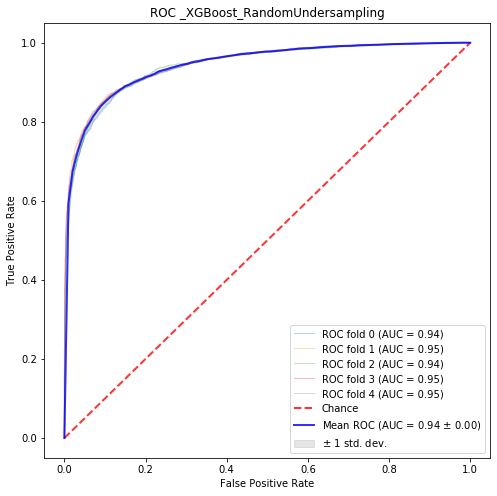

In [299]:
# Run classifier with cross-validation and plot ROC curves
import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve, auc


param_u = {'max_depth': 12,
          'learning_rate':0.02,          
          'min_child_weight': 1,
           'subsample': 1,
          'colsample_bytree': 1,
          'feature_fraction': 1,
          'max_delta_step': 1,
          'bagging_fraction':0.8,
          'tree_method': 'hist'
                                            }
#preds = np.zeros(len(x_test))
cv = StratifiedKFold(n_splits=5, random_state= 42, shuffle= True)
classifier_u = XGBClassifier(objective= 'binary:logistic',
                          n_estimators=2000, 
                            verbose = 100,
                            eval_metric='auc',
                              **param_u,
                              random_state= 42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))


i = 0
for trn_idx, val_idx in cv.split(x_train_u, y_train_u):
    x_trn_u, x_val_u = x_train_u.iloc[trn_idx, :], x_train_u.iloc[val_idx, :]
    y_trn_u, y_val_u = y_train_u.iloc[trn_idx], y_train_u.iloc[val_idx]
    print(' rows of train =',len(trn_idx),'rows of holdout =',len(val_idx))

    model_u= classifier_u.fit(x_trn_u, y_trn_u, eval_set=[(x_val_u, y_val_u)], early_stopping_rounds = 100)
    u_probas_ = model_u.predict_proba(x_val_u)
    # predict for test set
    #preds += model.predict_proba(x_test)[:,1]/cv.n_splits

    # Compute PR_ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_val_u, u_probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i,roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr= np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC _XGBoost_RandomUndersampling')
plt.legend(loc="lower right")
plt.show()

In [300]:
#Extracting the best iteration
best_iteration_u = model_u.get_booster ().best_ntree_limit
best_iteration_u

1892

## prediction with best parameters

In [310]:
# prediction
preds_u = model_u.predict_proba(x_test, ntree_limit= best_iteration_u)[:, 1]

In [311]:
#Printing the classification report
from sklearn.metrics import classification_report, confusion_matrix
for i in range(0,len(y_test)):
    if preds_u[i]>=.5:       # setting threshold to .5
       preds_u[i]=1
    else:  
       preds_u[i]=0
print(confusion_matrix(y_test, preds_u))
print(classification_report (y_test, preds_u))
auc = roc_auc_score(y_test,preds_u)
print(f'ROC_AUC_undersampled: {auc}')

[[101800  12175]
 [   586   3547]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    113975
           1       0.23      0.86      0.36      4133

    accuracy                           0.89    118108
   macro avg       0.61      0.88      0.65    118108
weighted avg       0.97      0.89      0.92    118108

ROC_AUC_undersampled: 0.8756963503538067


Xgb: f1=0.357 PR_AUC=0.544


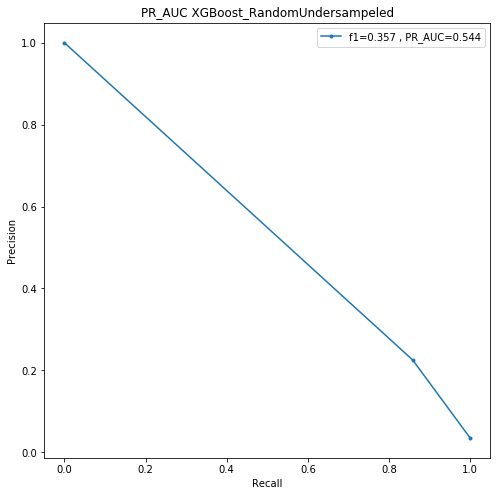

In [314]:
# calculate precision-recall curve
from sklearn.metrics import f1_score, auc

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, preds_u)
xgb_f1, xgb_PR_auc = f1_score(y_test, preds_u), auc(xgb_recall, xgb_precision)
print('Xgb: f1=%.3f PR_AUC=%.3f' % (xgb_f1, xgb_PR_auc))
plt.figure(figsize=(8, 8))
plt.plot(xgb_recall, xgb_precision, marker='.', label='f1=%.3f , PR_AUC=%.3f' % (xgb_f1, xgb_PR_auc))
# plot title
plt.title('PR_AUC XGBoost_RandomUndersampeled')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

0.8756963503538067


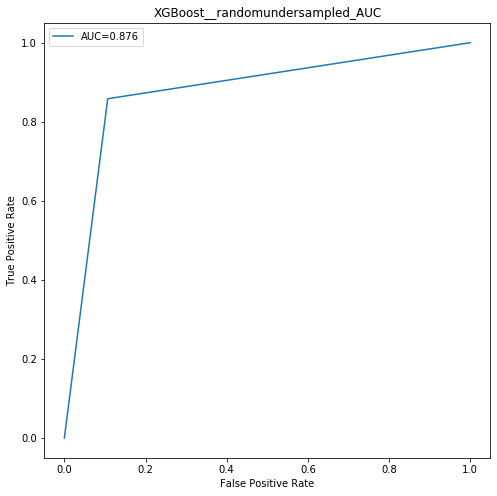

In [315]:
# calculate and print the roc curve
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, preds_u)
xgb_auc = auc(xgb_fpr, xgb_tpr)
print(xgb_auc)
plt.figure(figsize=(8,8))
plt.plot(xgb_fpr, xgb_tpr, label='AUC=%.3f' % ( xgb_auc))
plt.title('XGBoost__randomundersampled_AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Feature Importance

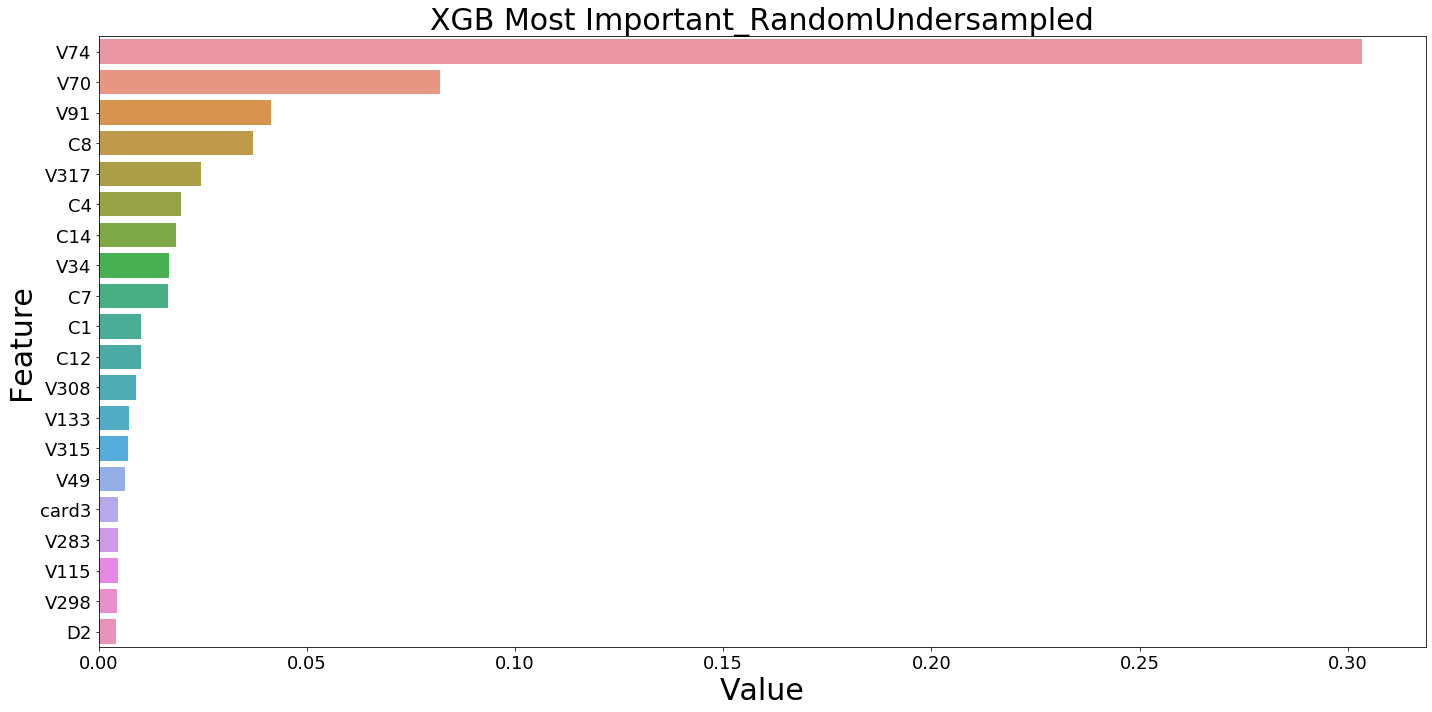

In [316]:
import seaborn as sns
cols = list( x_train_u.columns )
feature_imp = pd.DataFrame(sorted(zip(model_u.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
b= sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
b.set_xlabel("Value",fontsize=30)
b.set_ylabel("Feature",fontsize=30)
b.tick_params(labelsize=18)

plt.title('XGB Most Important_RandomUndersampled', fontsize= 30)
plt.tight_layout()
plt.show()